This notebook may be used as a start for your exploration of time series analysis using multi-layer neural network, which weights are selected with NSGA-II algorithm with respect to two opposite criteria (objectives) of PICP and PINRW.

X.csv and F.csv in this folder contain the computed solution vectors as well as objectives values, where 1-PICP is the first column, PINRW is the second column.

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2023-11-06 19:06:22.813765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 19:06:28.139775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-06 19:06:28.139826: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-06 19:06:38.225133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared

In [15]:
!pip show pymoo || pip install pymoo
from pymoo.core.problem import ElementwiseProblem


Name: pymoo
Version: 0.6.0.1
Summary: Multi-Objective Optimization in Python
Home-page: https://pymoo.org
Author: Julian Blank
Author-email: blankjul@msu.edu
License: Apache License 2.0
Location: /home/alexander/mambaforge/lib/python3.9/site-packages
Requires: alive-progress, autograd, cma, Deprecated, dill, matplotlib, numpy, scipy
Required-by: 


In [16]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [17]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [18]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)



In [19]:
df.head()

<DATE>  <CLOSE>
0 2003-03-03   352.24
1 2003-03-04   348.40
2 2003-03-05   357.65
3 2003-03-06   359.97
4 2003-03-07   354.87

In [20]:
df.tail()

<DATE>  <CLOSE>
5005 2023-03-23  2388.35
5006 2023-03-24  2391.53
5007 2023-03-27  2440.68
5008 2023-03-28  2442.19
5009 2023-03-29  2444.90

In [21]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [22]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


In [23]:
df.tail()

<DATE>  <CLOSE>
5005 2023-03-23  2388.35
5006 2023-03-24  2391.53
5007 2023-03-27  2440.68
5008 2023-03-28  2442.19
5009 2023-03-29  2444.90

In [24]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [25]:
df[:train_size].tail()

<DATE>  <CLOSE>
4003 2019-03-11  2465.94
4004 2019-03-12  2468.25
4005 2019-03-13  2470.61
4006 2019-03-14  2457.79
4007 2019-03-15  2476.73

In [26]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))

In [27]:
X_test = test_scaled[:-12]
y_test = test_scaled[12:]

In [28]:
X_train = train_scaled[:-12]
y_train = train_scaled[12:]

In [29]:
X_train = np.hstack((X_train[:-5], X_train[1:-4], X_train[2:-3], X_train[3:-2], X_train[4:-1], X_train[5:]))
X_test = np.hstack((X_test[:-5], X_test[1:-4], X_test[2:-3], X_test[3:-2], X_test[4:-1], X_test[5:]))

In [30]:
X_train.shape

(3991, 6)

In [31]:
y_train.shape

(3996, 1)

In [32]:
X_test.shape

(985, 6)

In [33]:
y_test.shape

(990, 1)

In [34]:
# Define the model
model = Sequential([
    Dense(units=6),
    Dense(units=3),
    Dense(units=2)
])

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

2023-11-06 19:15:48.381859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-06 19:15:48.382079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-06 19:15:48.382167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-06 19:15:48.382378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

In [35]:
shape = get_shape(model)

In [36]:
model.count_params()

71

In [37]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=model.count_params(),
                         n_obj=2,
                         xl=np.full(model.count_params(), -1),
                         xu=np.full(model.count_params(), 1)
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        global model, shape, X_train, y_train
        model.set_weights(set_shape(x,shape))
        predictions = model.predict(X_train)
        f1 = 1 - PICP(y_train, predictions)
        f2 = PINRW(predictions)

        out["F"] = [f1, f2]

problem = MyProblem()

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [41]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=model.count_params() + 2,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)



In [42]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 500)

In [43]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

125/125 [==============================] - 0s 604us/step
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       73 |      7 |             - |             -
125/125 [==============================] - 0s 569us/step
     2 |       83 |      7 |  0.0097636131 |             f
125/125 [==============================] - 0s 619us/step
     3 |       93 |      7 |  0.000000E+00 |             f
125/125 [==============================] - 0s 620us/step
     4 |      103 |      7 |  0.000000E+00 |             f
125/125 [==============================] - 0s 619us/step
     5 |      113 |      5 |  1.0502353680 |         nadir
125/125 [==============================] - 0s 611us/step
     6 |      123 |      5 |  0.000000E+00 |             f
125/125 [==============================] - 0s 646us/step
     7 |      133 |      5 |  0.000000E+00 |             f
125/125 [==============================] - 0s 588us/step
     8 |      143 |      5 |  0.000000E+00 |             f
125/125 [====

In [44]:
X_df = pd.DataFrame(X)

In [45]:
F_df = pd.DataFrame(F)

In [46]:
X_df.to_csv('6_days_ahead_X.csv')

In [47]:
F_df.to_csv('6_days_ahead_F.csv')

In [48]:
F_df = pd.read_csv('6_days_ahead_F.csv')
F = np.array(F_df.iloc[:,1:])
X_df = pd.read_csv('6_days_ahead_X.csv')
X = np.array(X_df.iloc[:,1:])

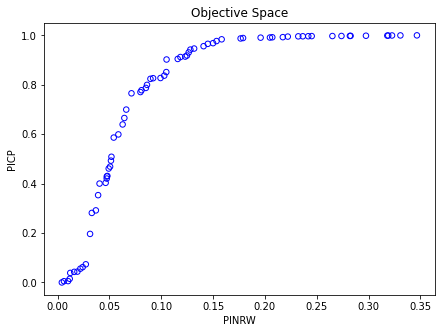

In [49]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], 1 - F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel('PINRW')
plt.ylabel('PICP')
plt.show()

In [50]:
y_test_unscaled = scaler.inverse_transform(y_test)

<H1> Predictions section:

In [51]:
from matplotlib.backends.backend_pdf import PdfPages

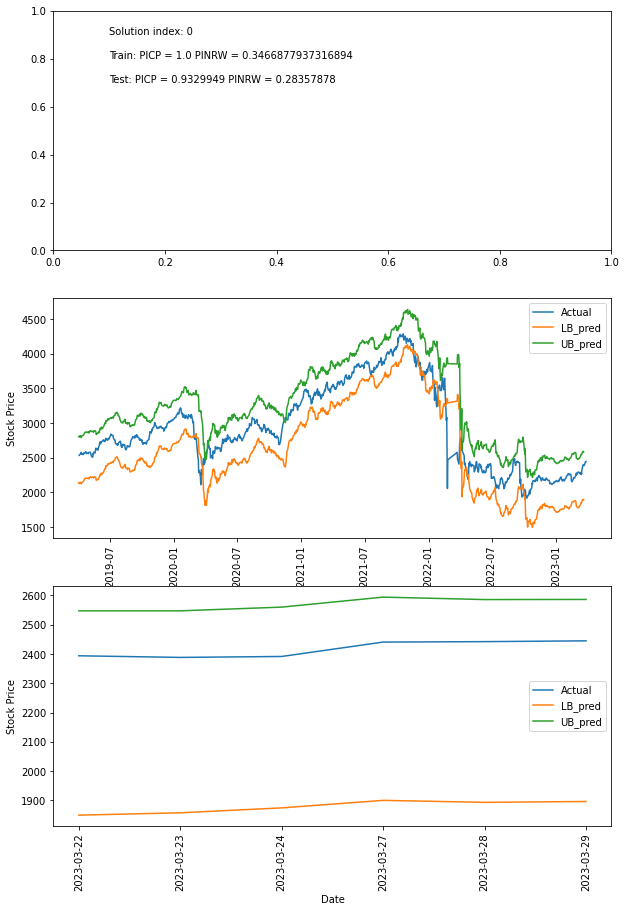

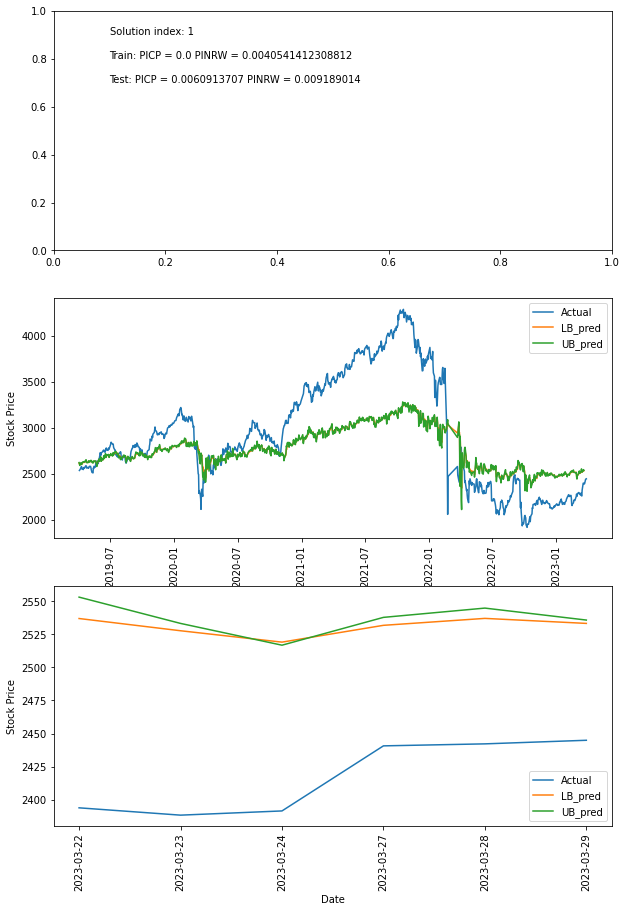

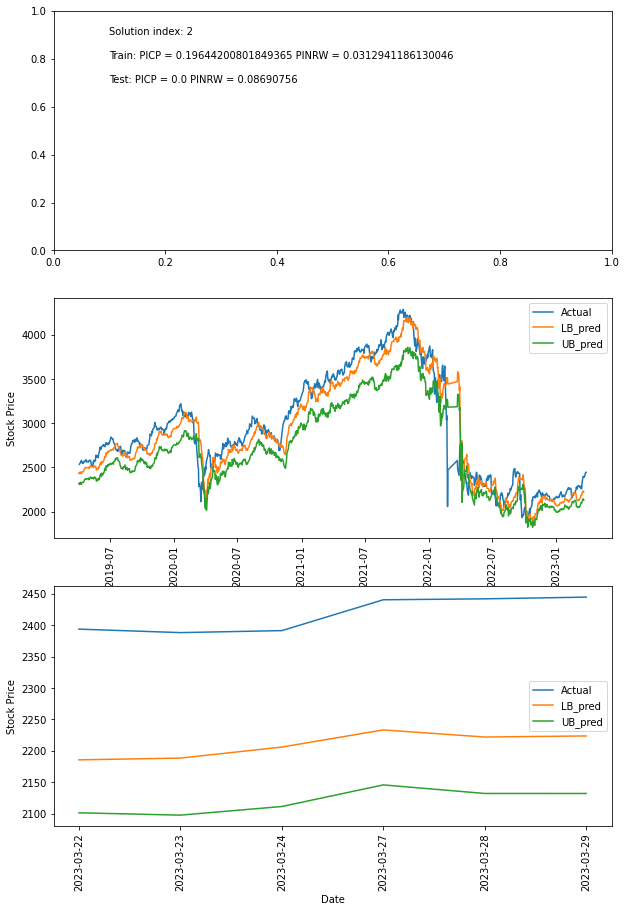

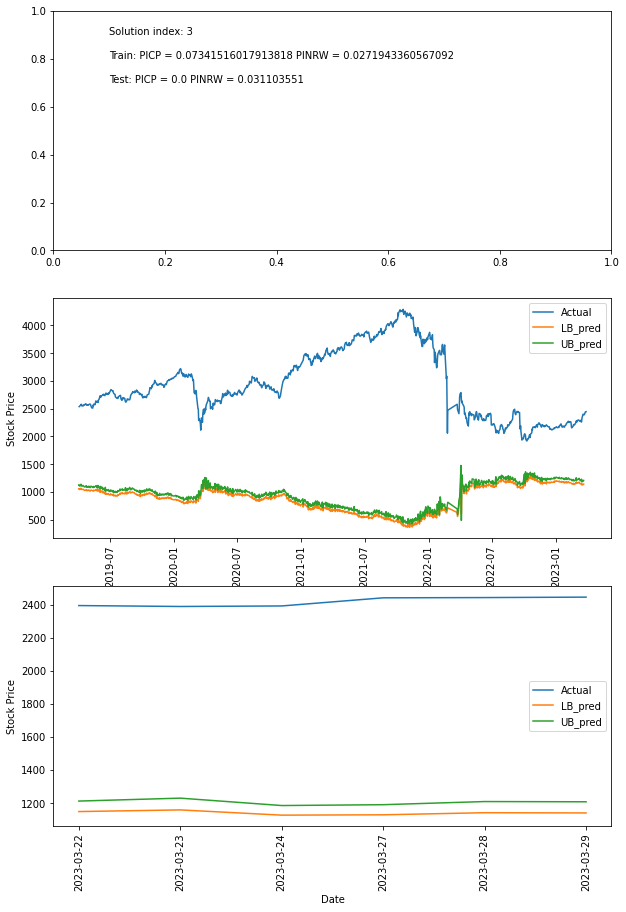

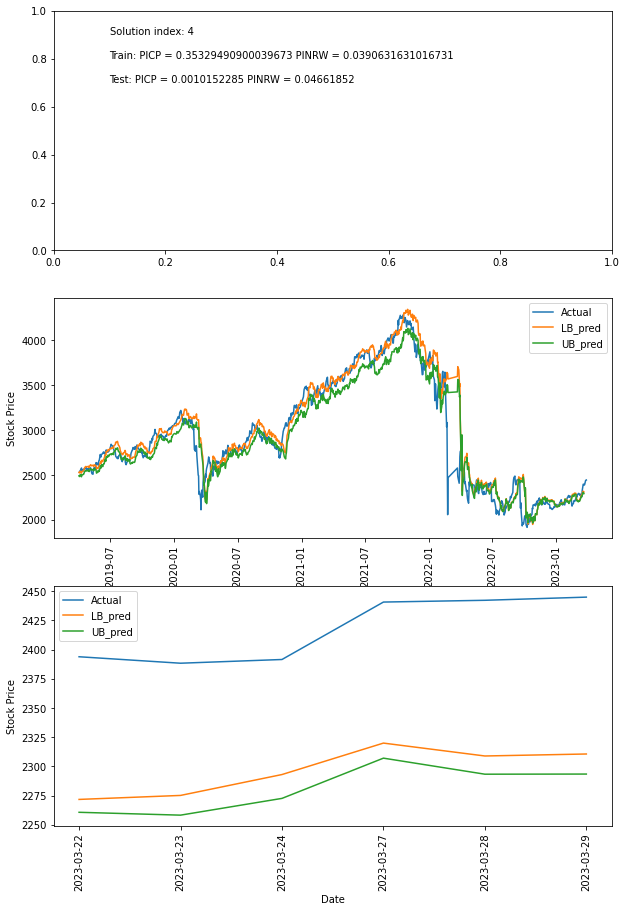

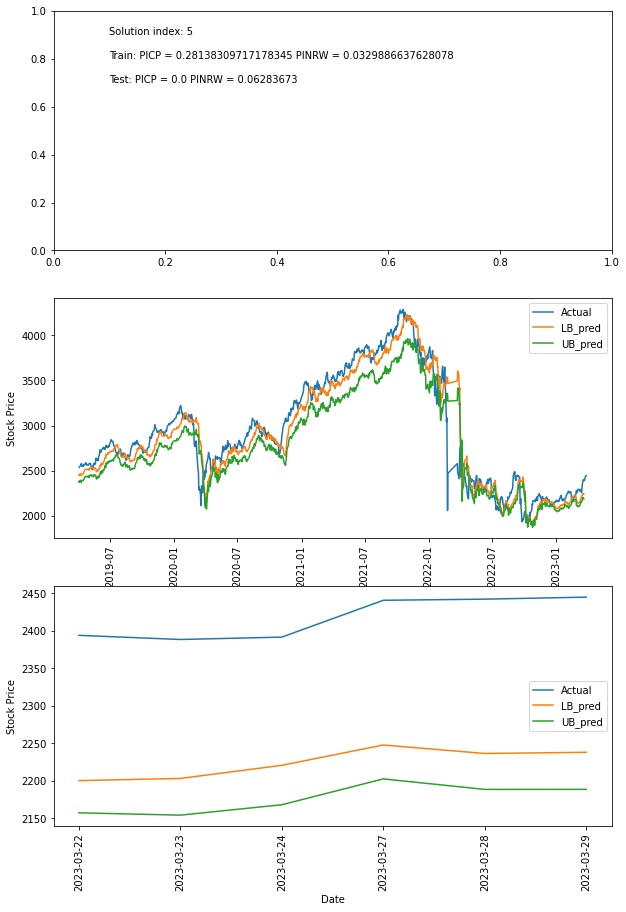

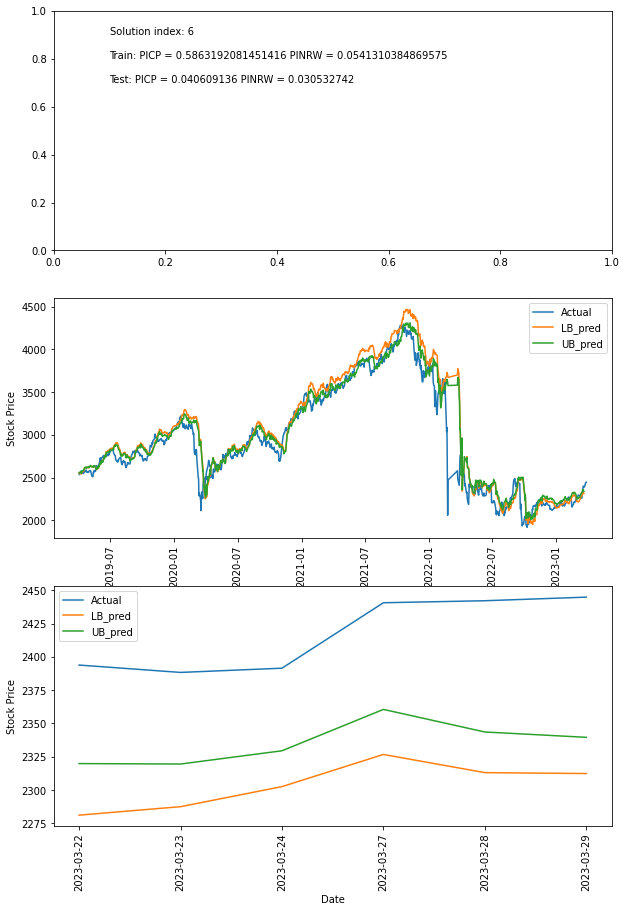

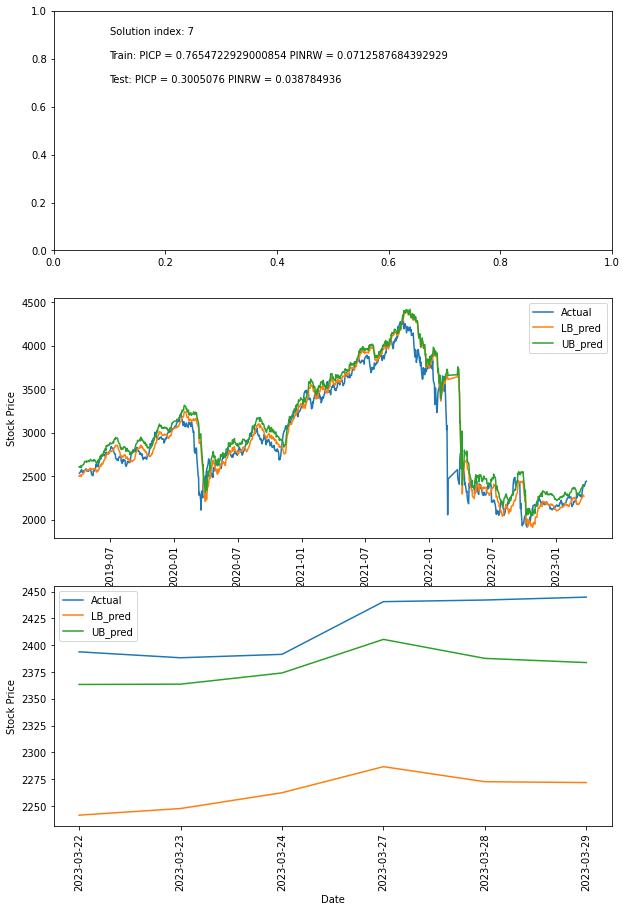

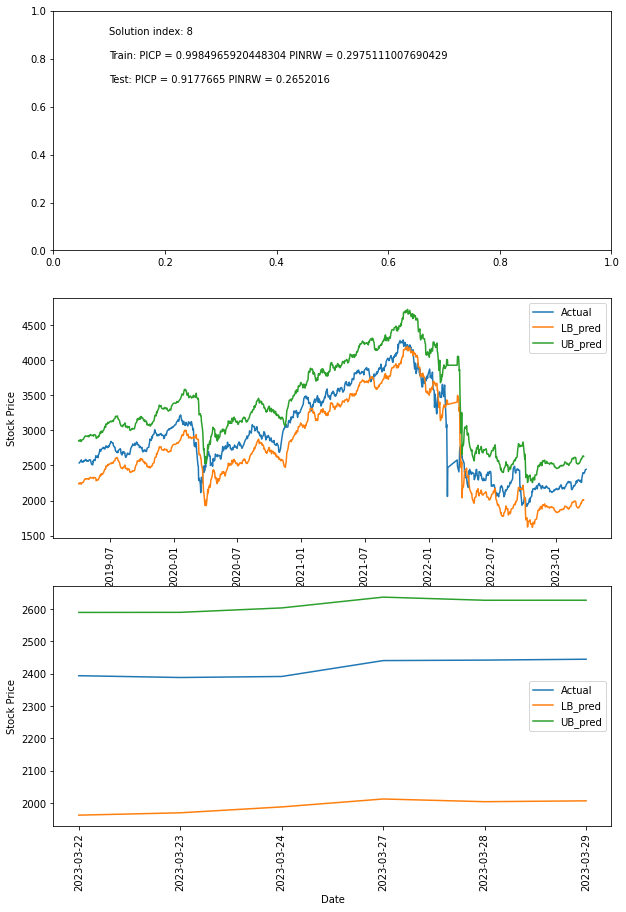

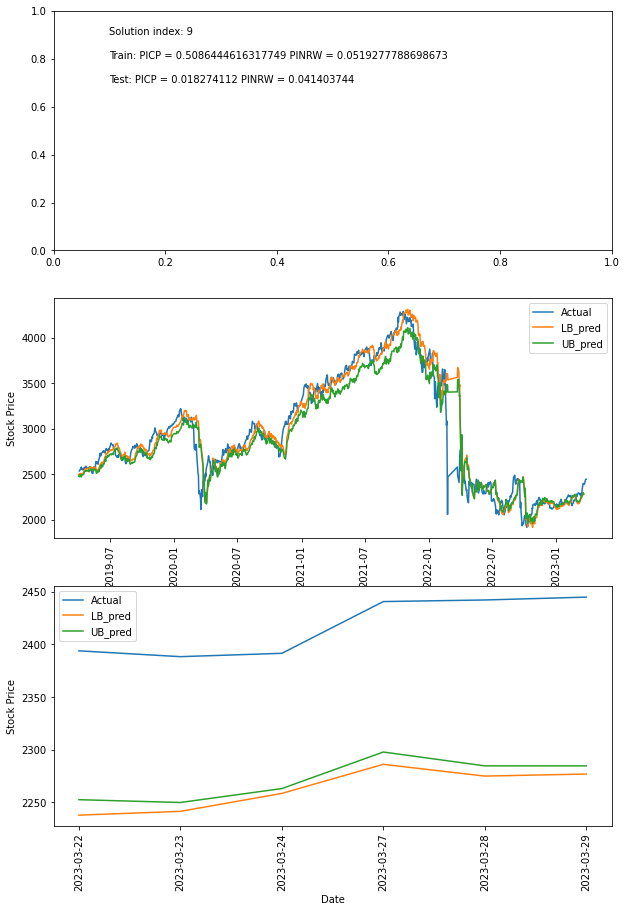

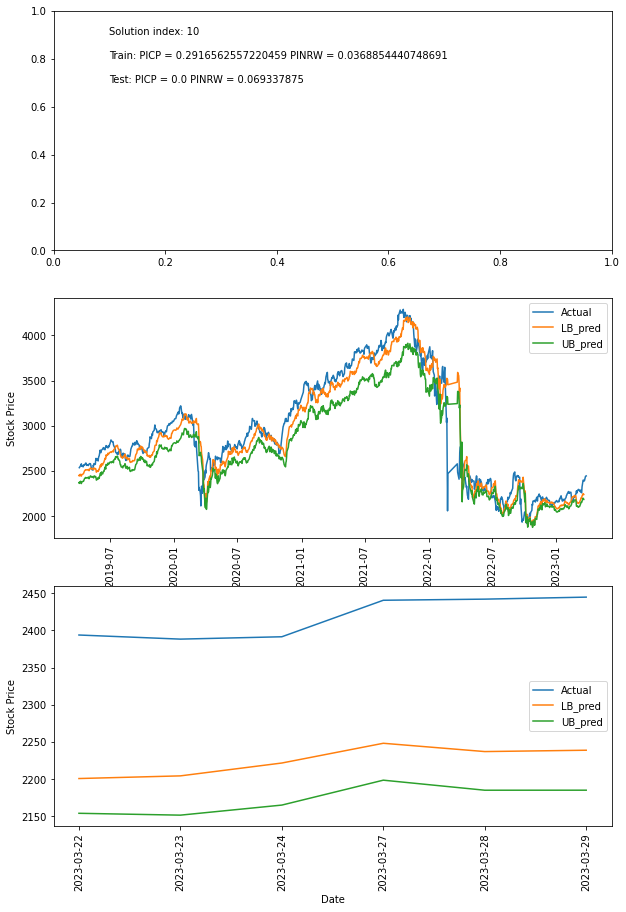

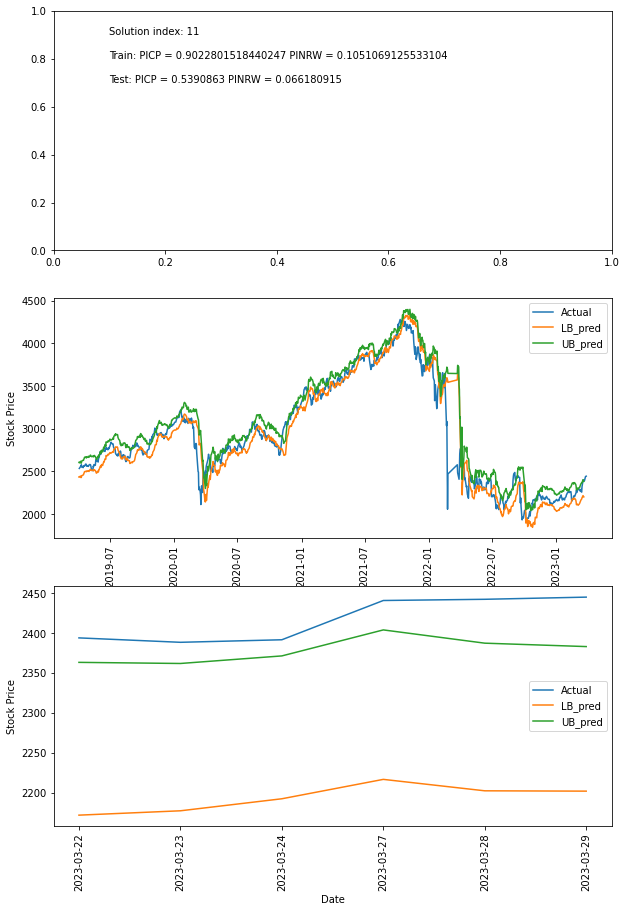

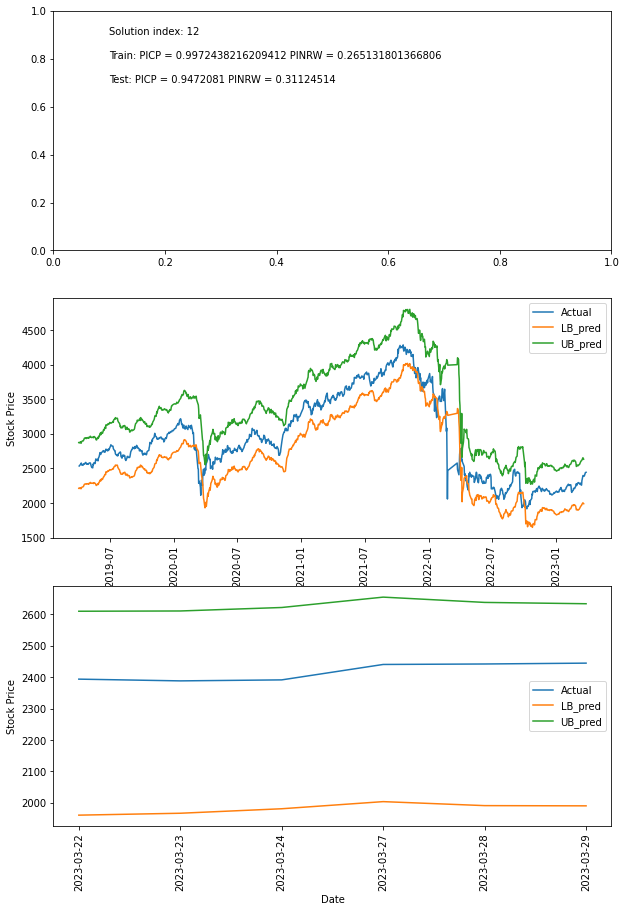

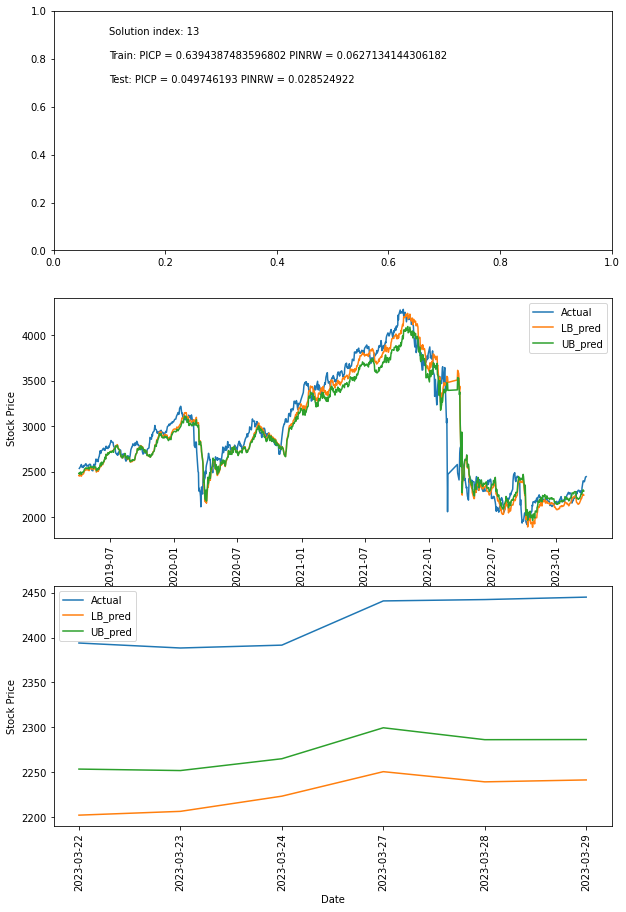

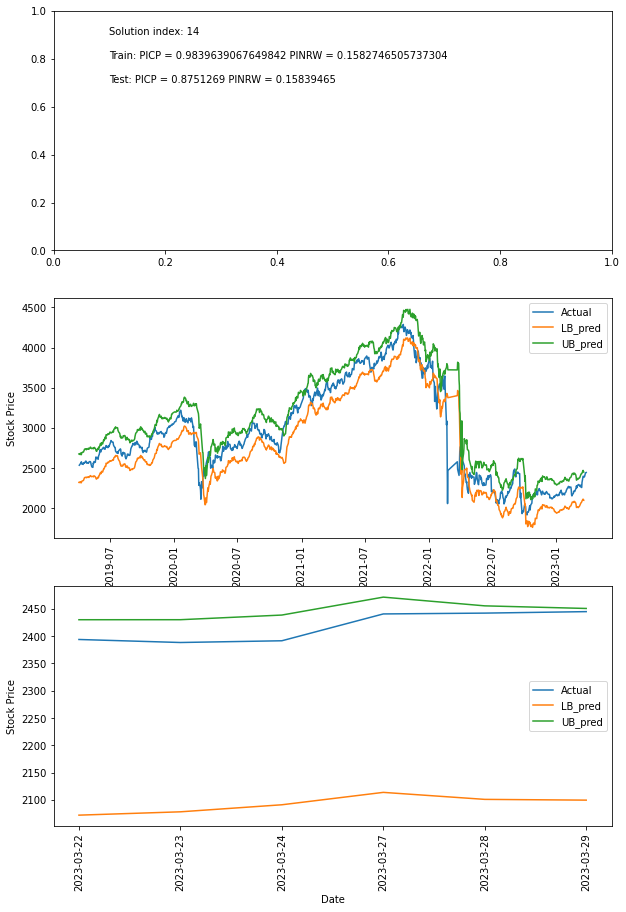

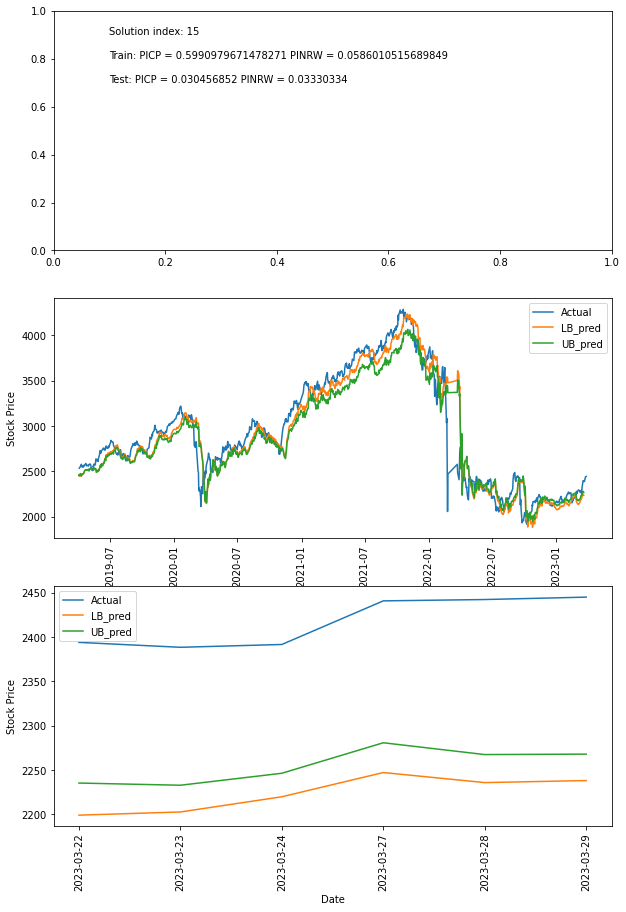

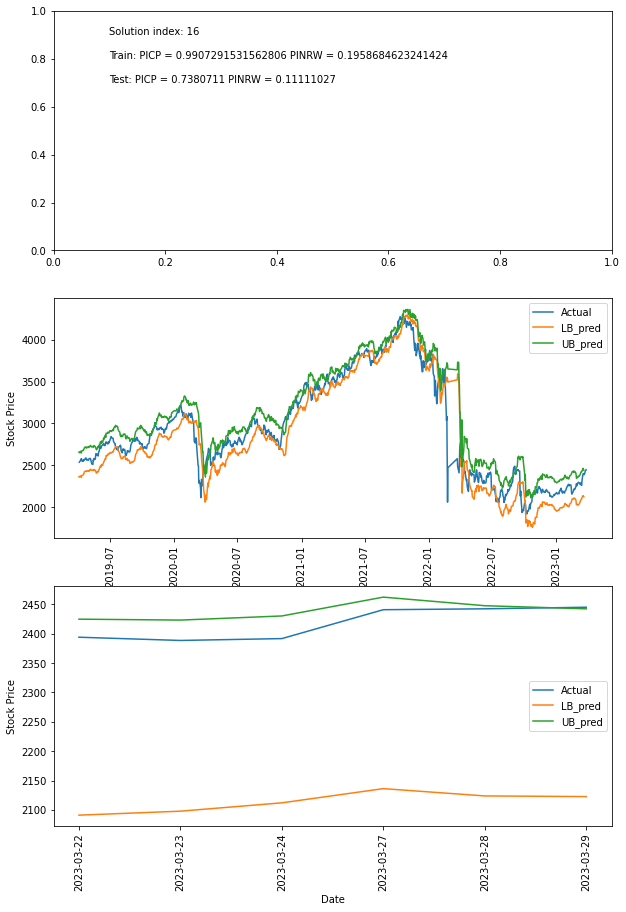

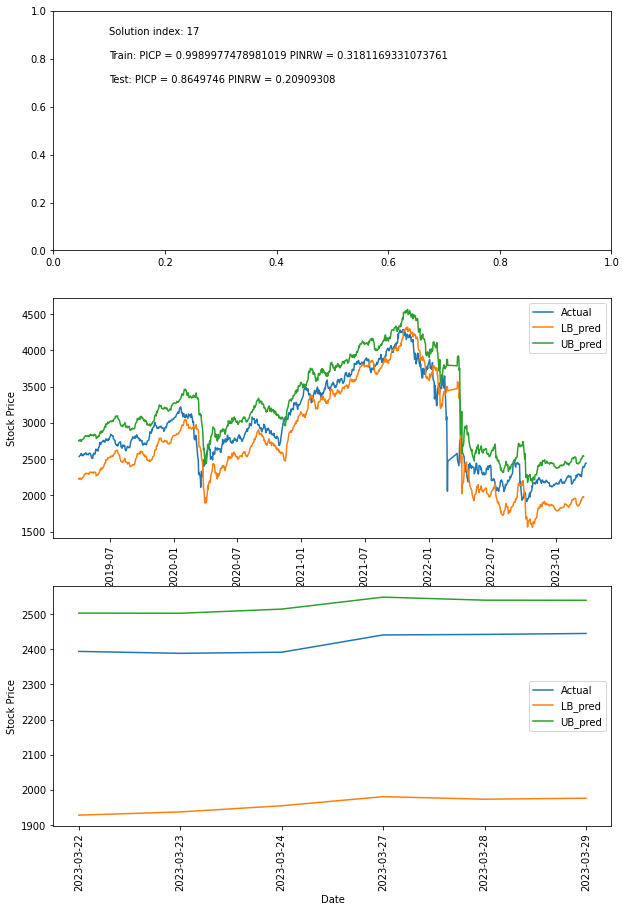

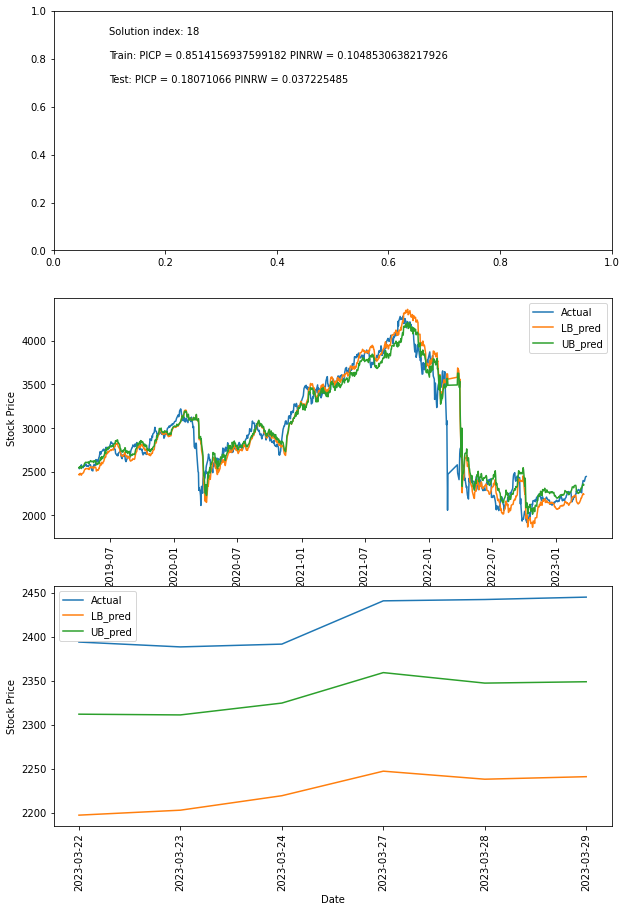

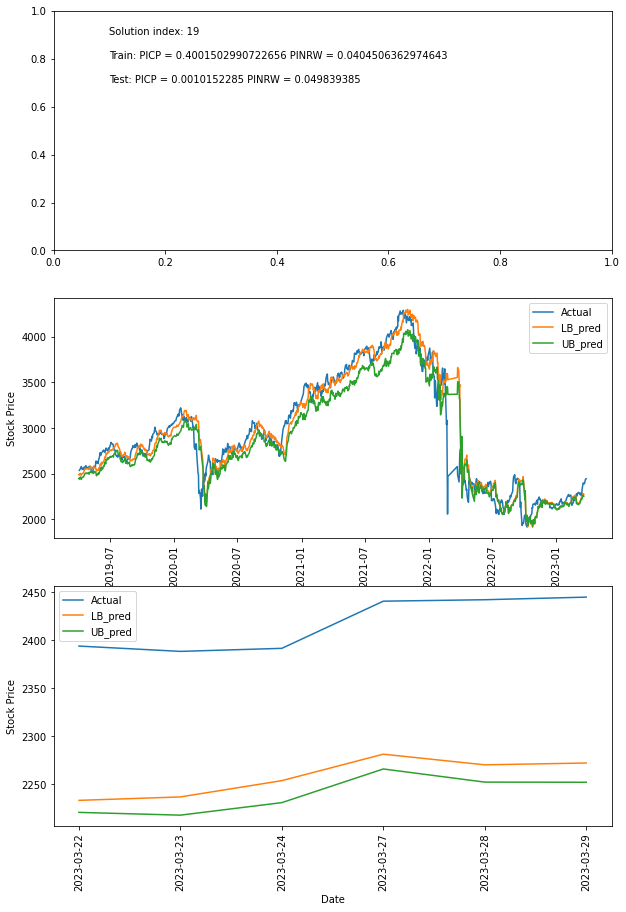

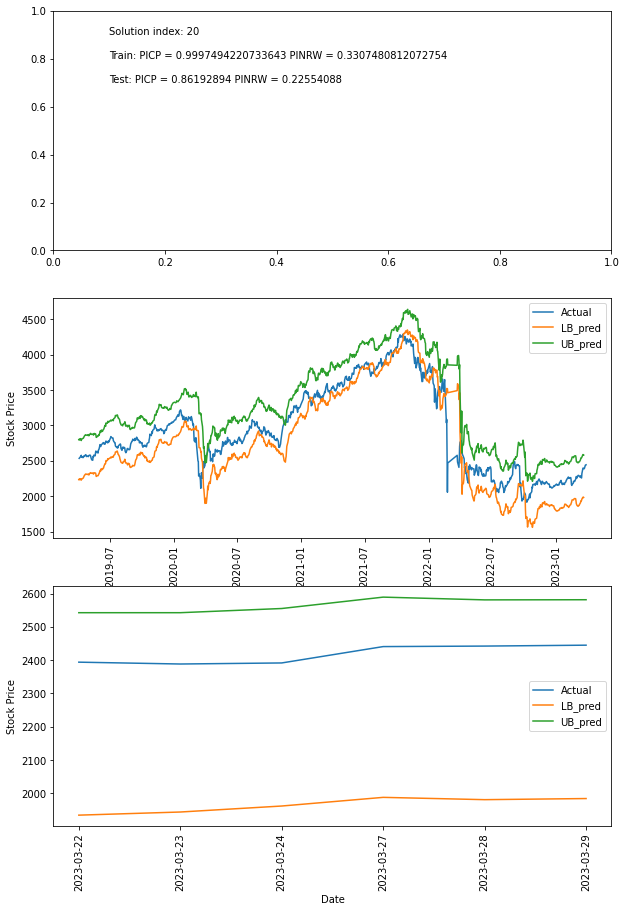

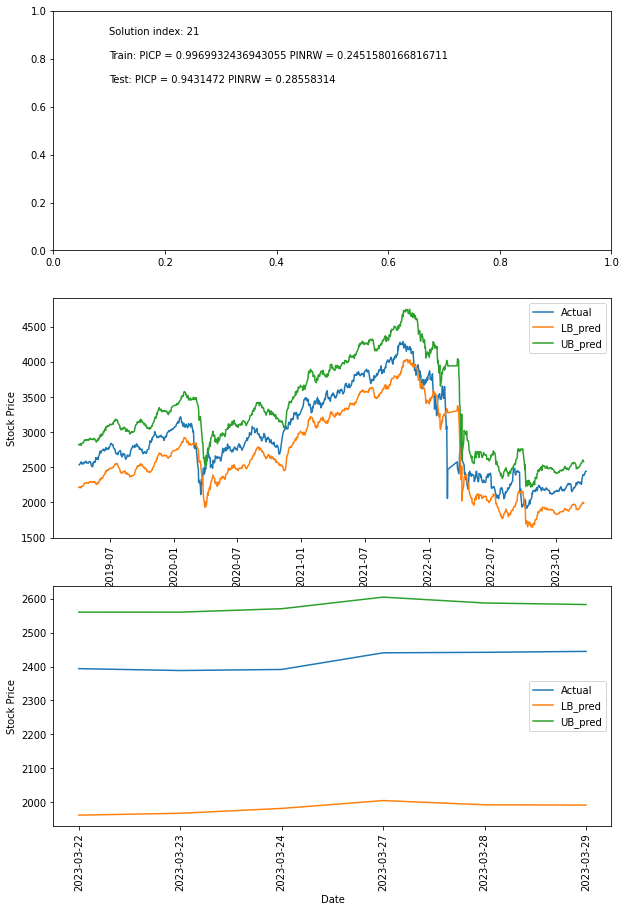

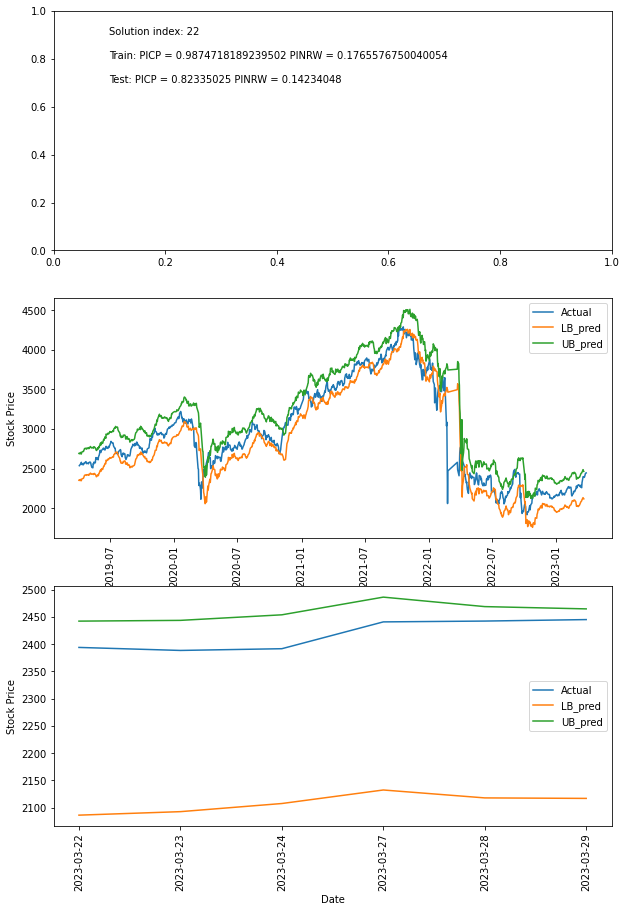

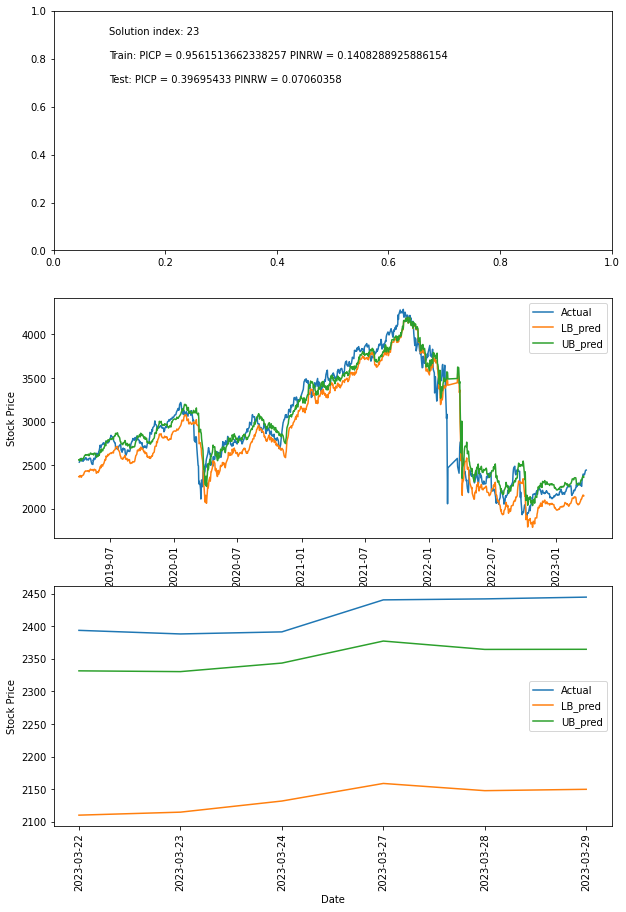

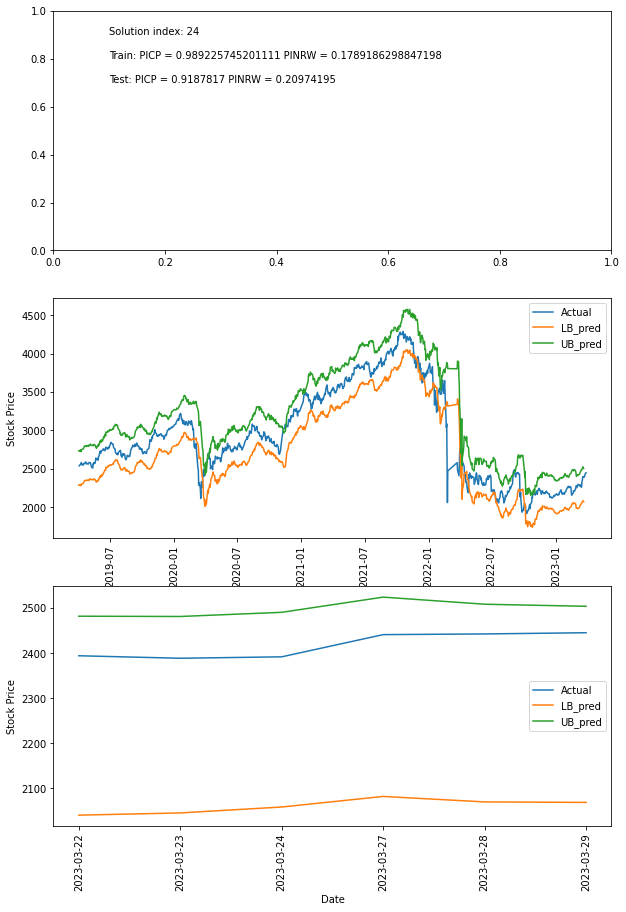

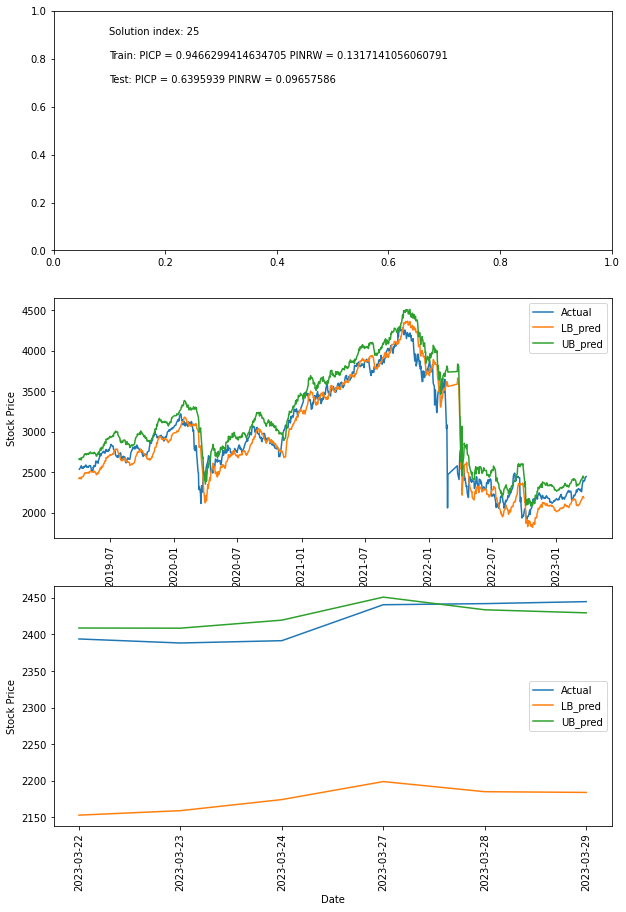

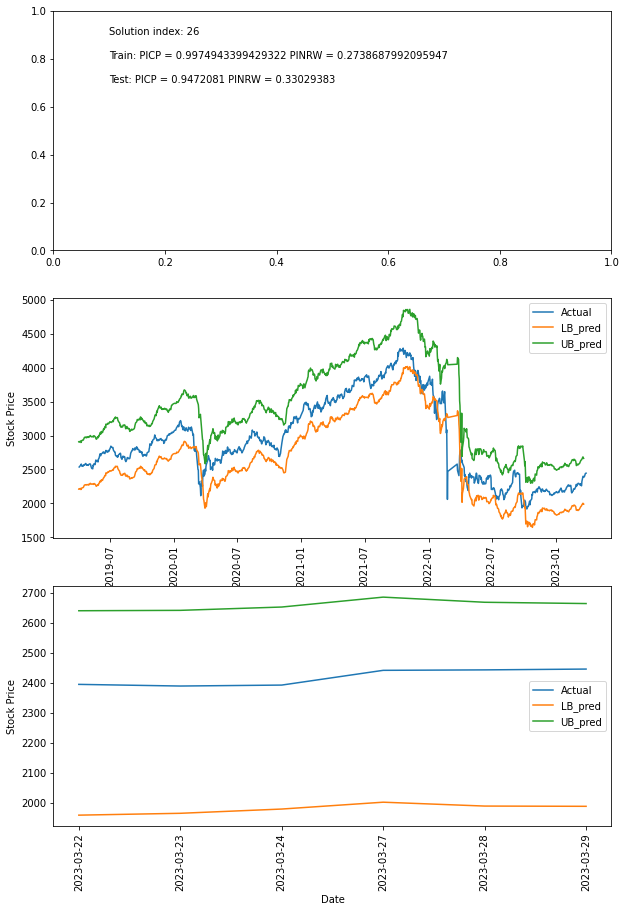

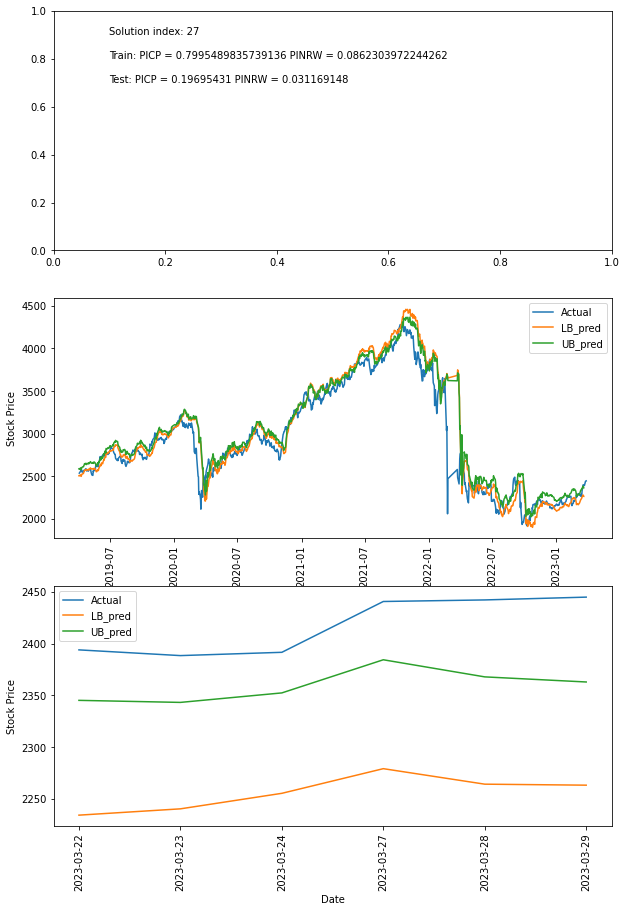

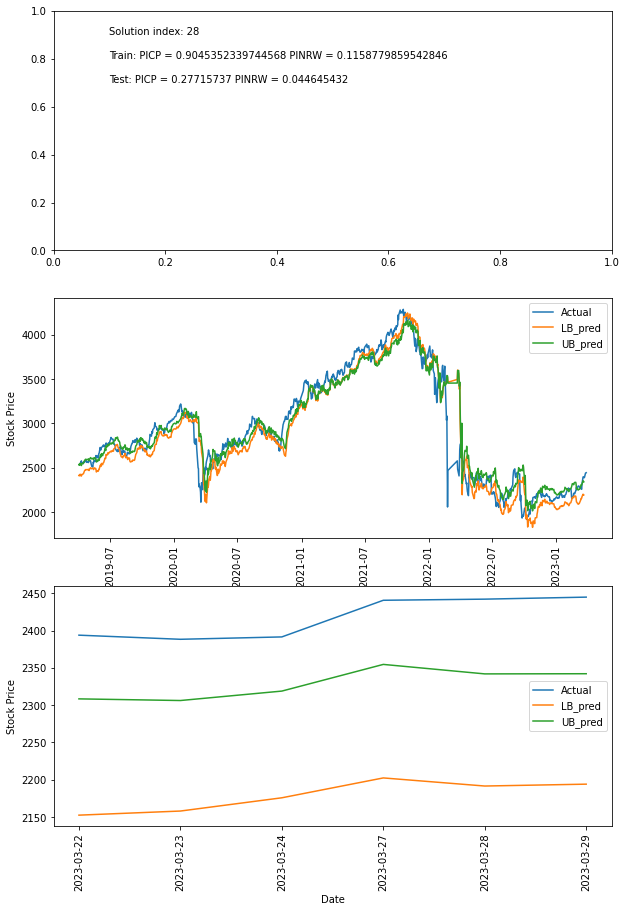

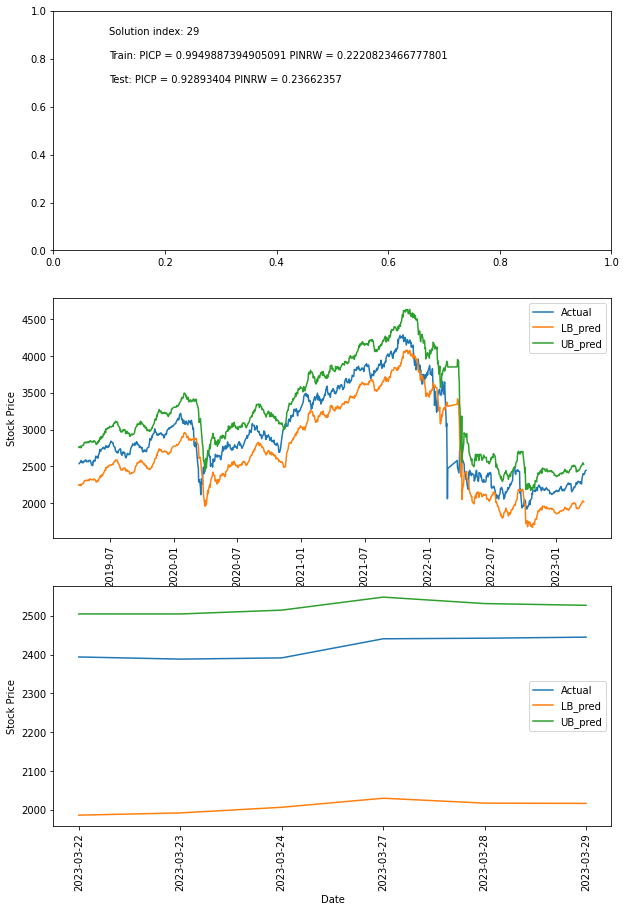

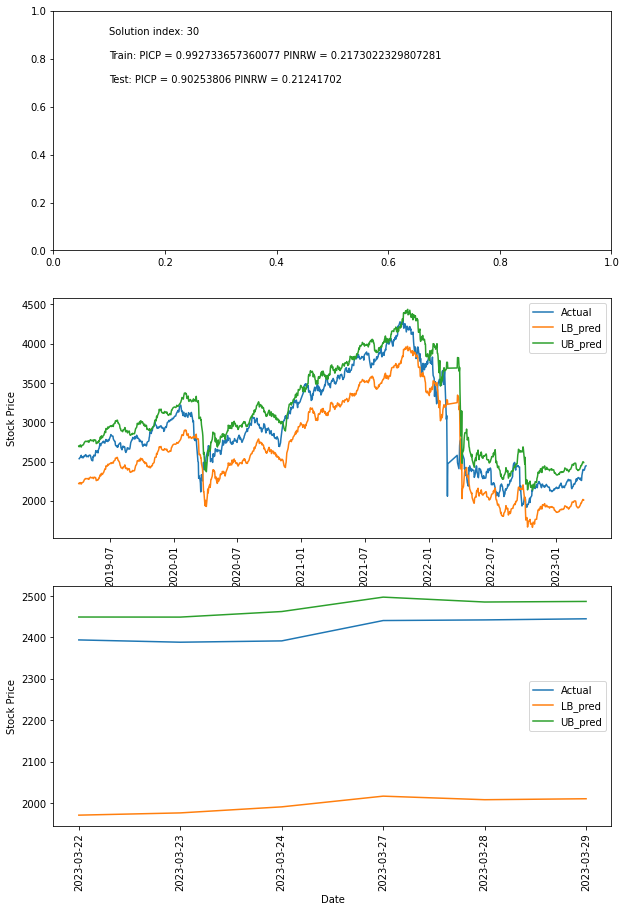

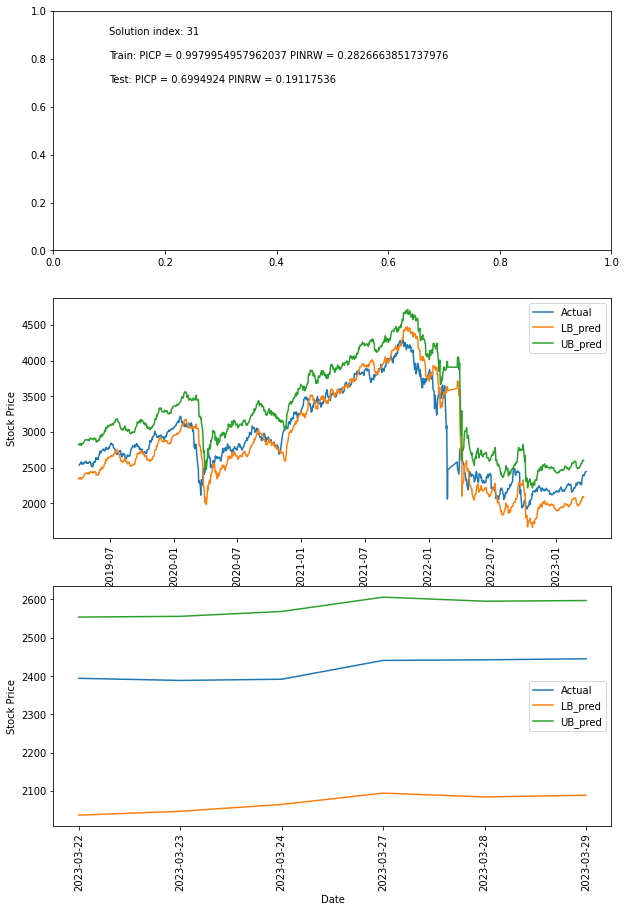

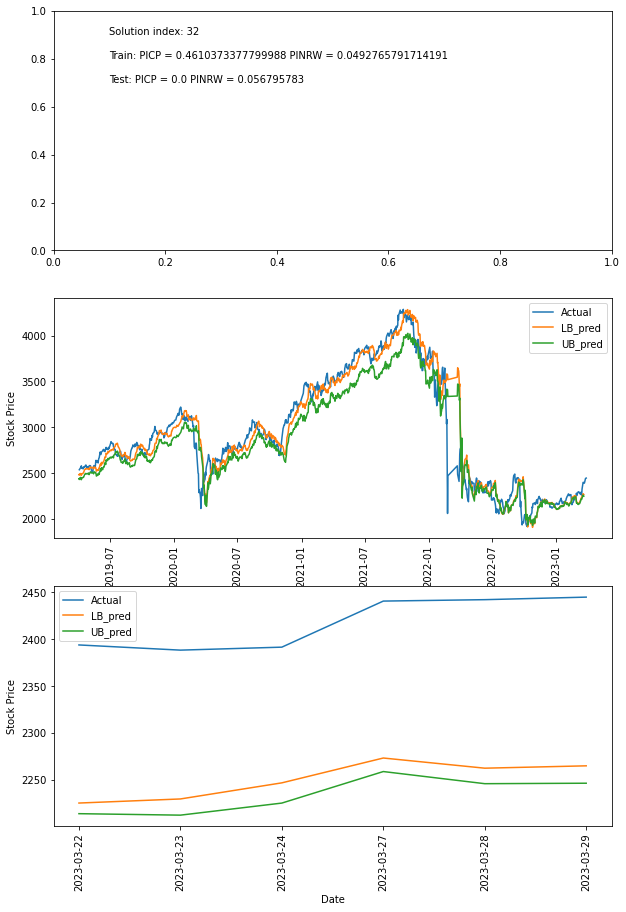

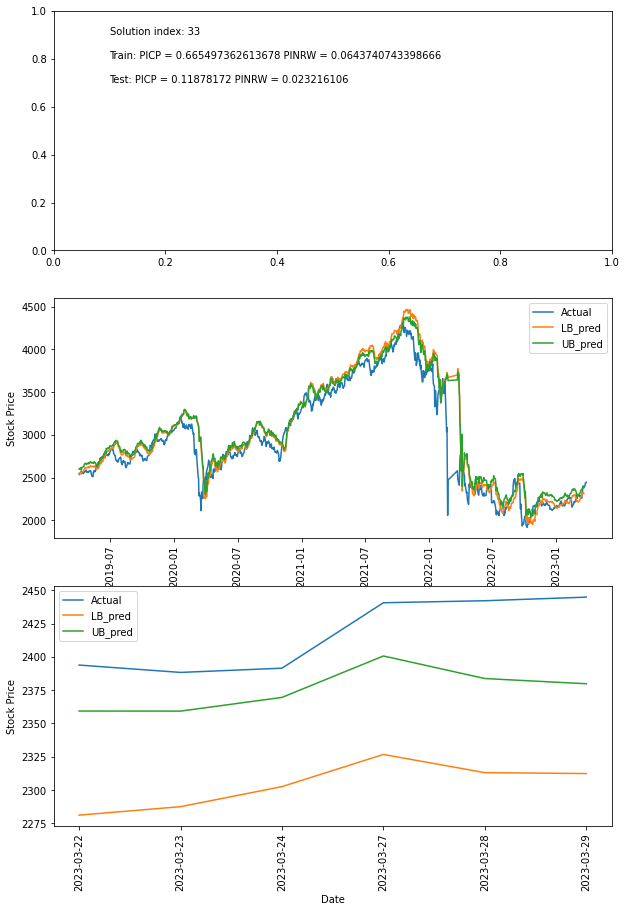

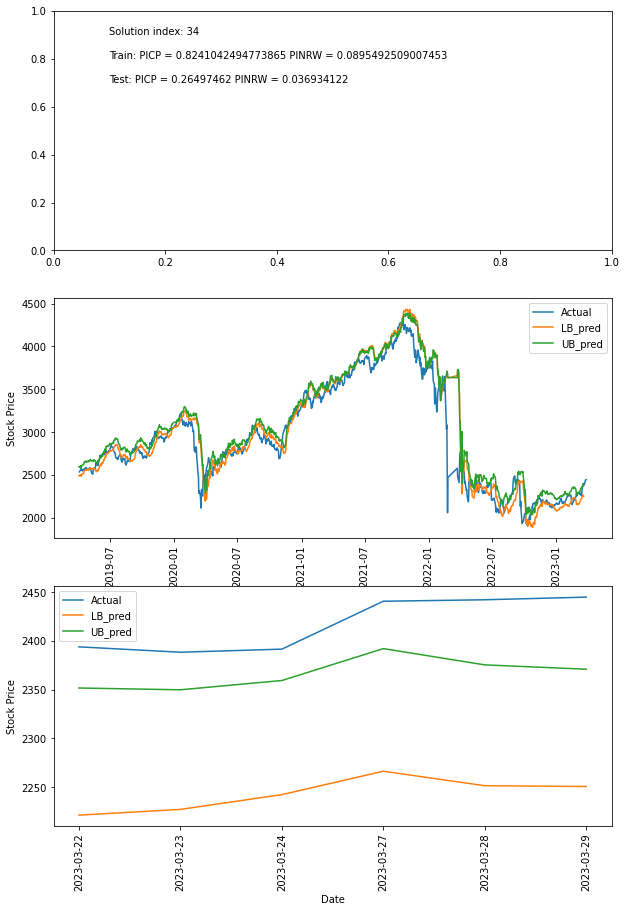

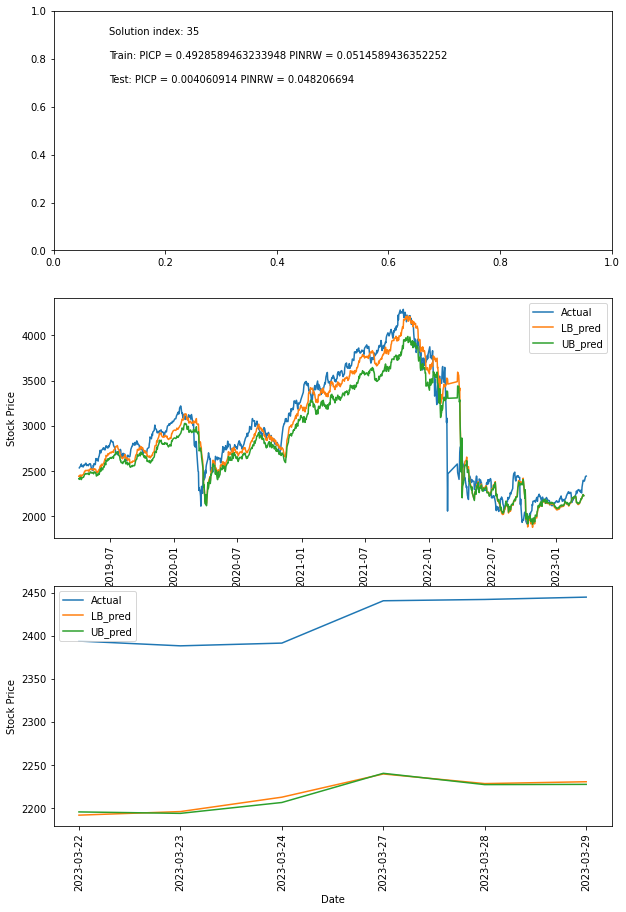

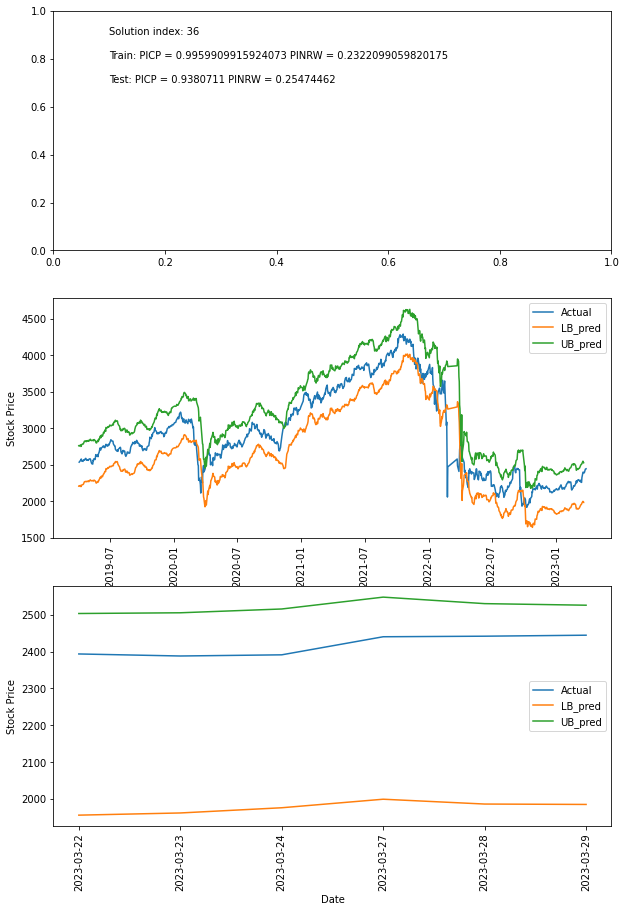

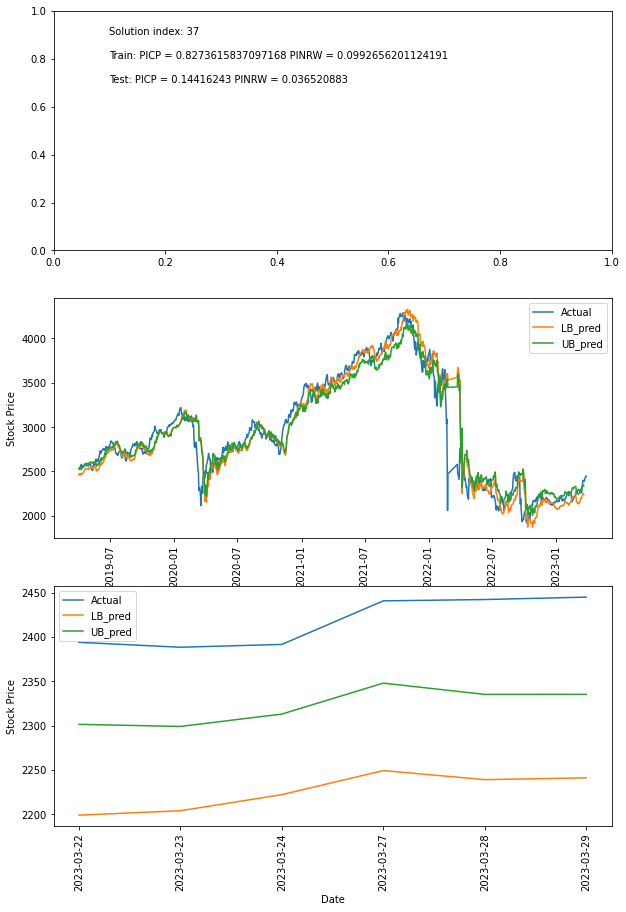

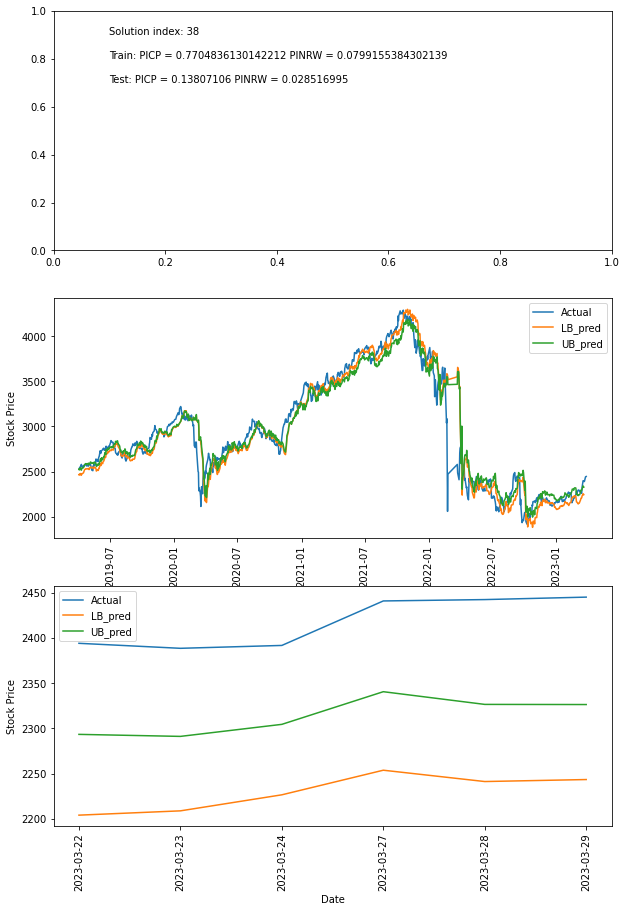

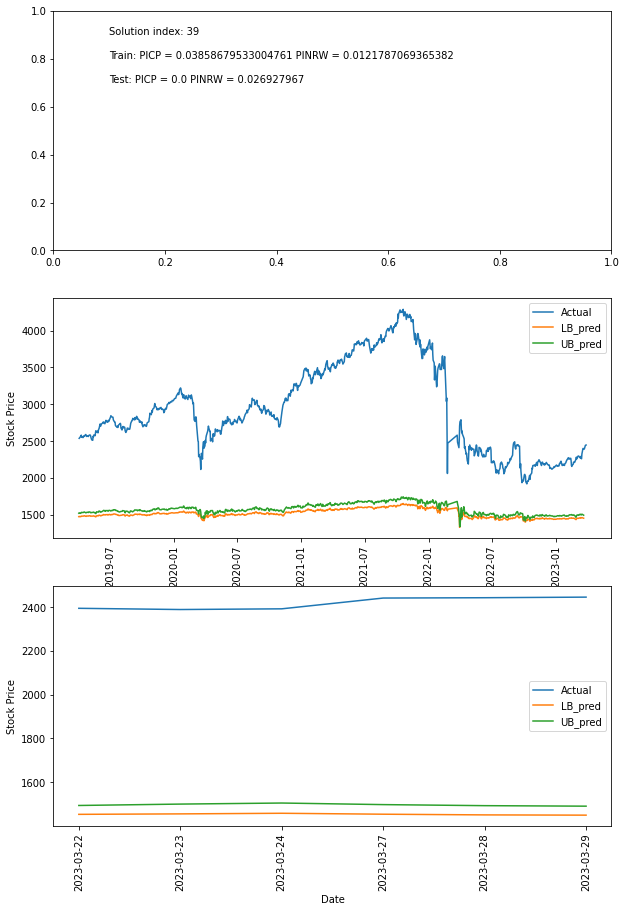

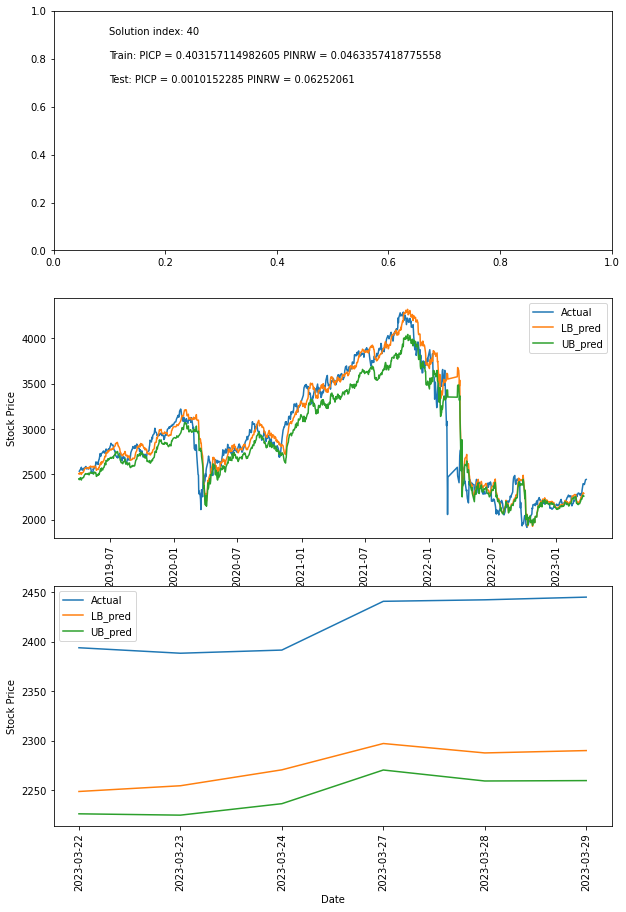

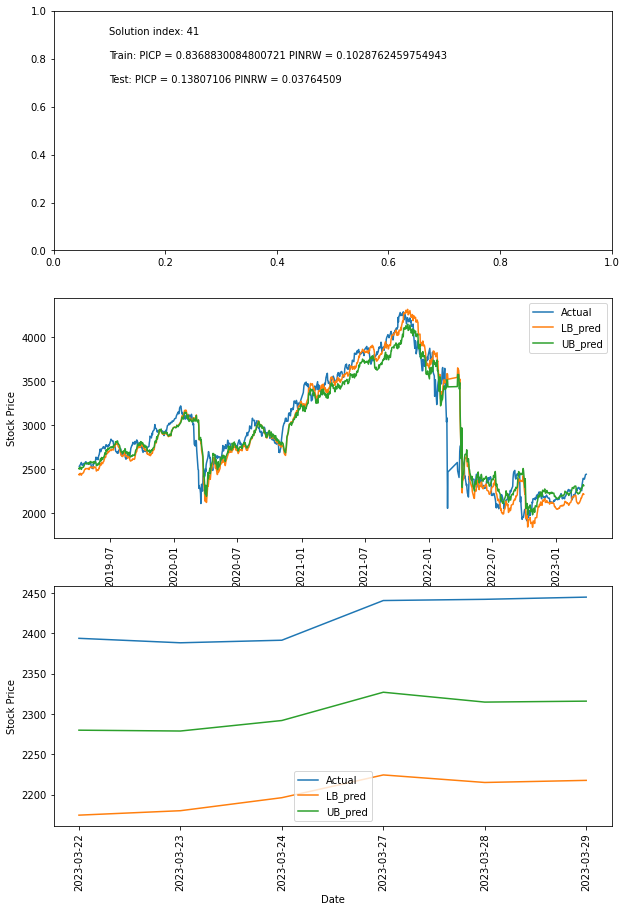

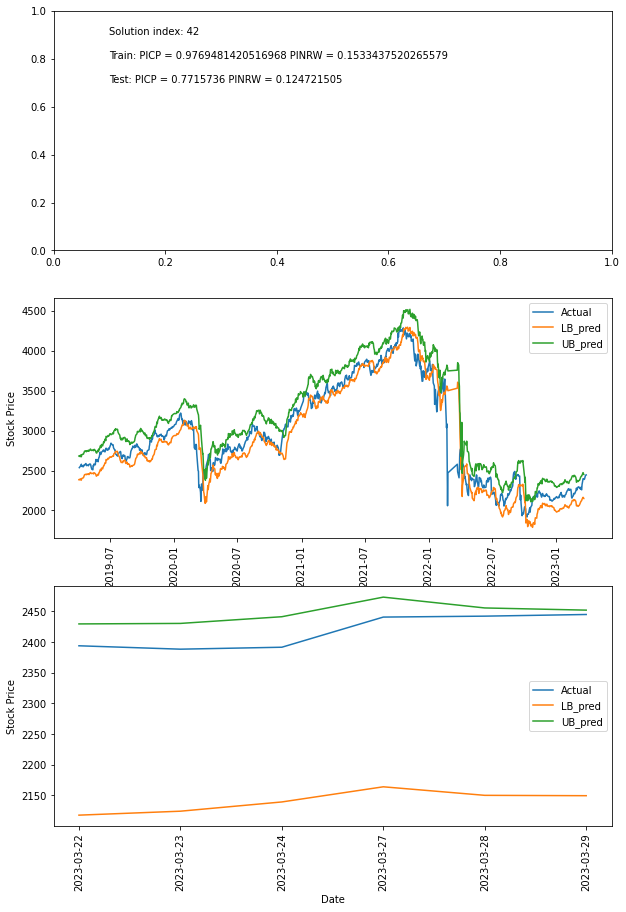

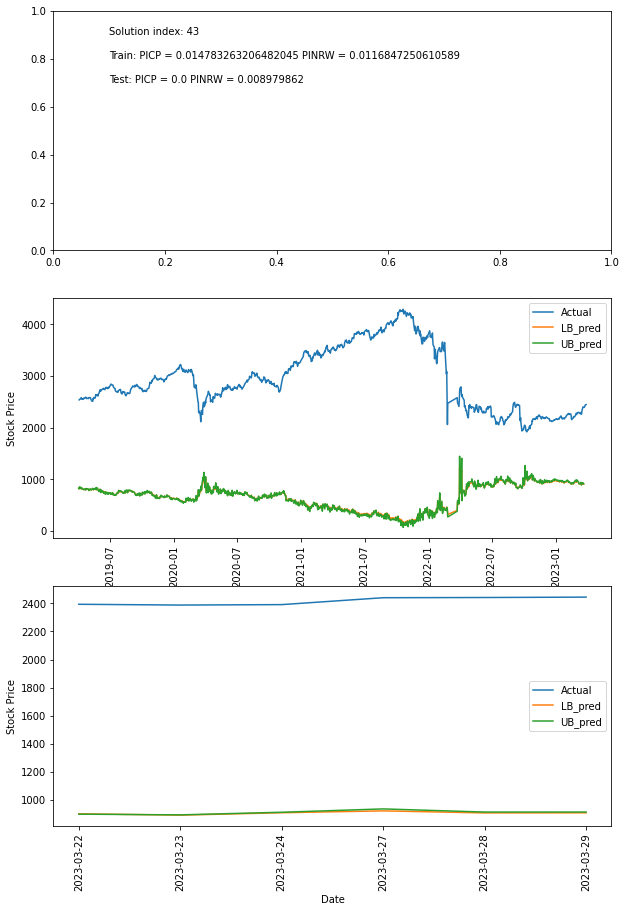

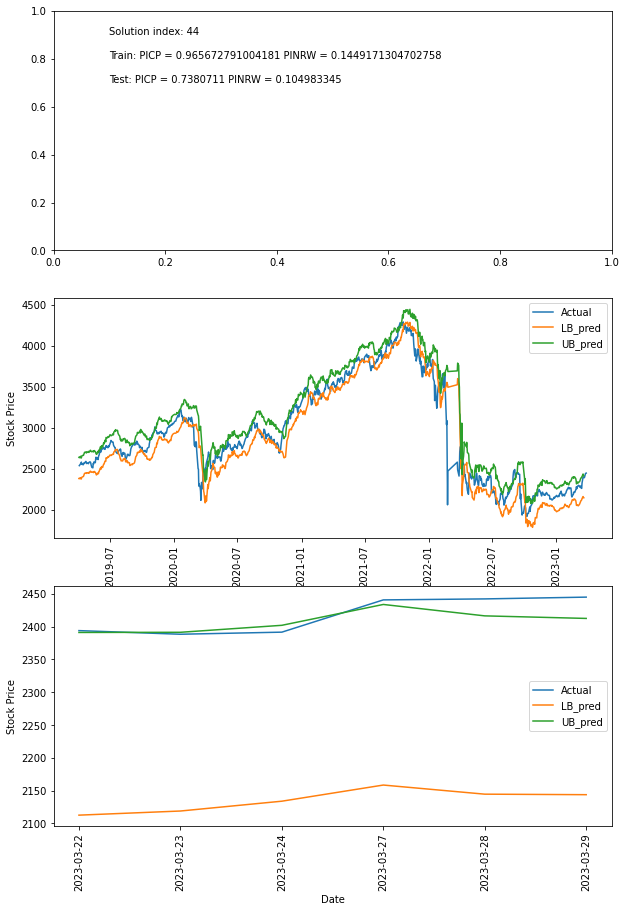

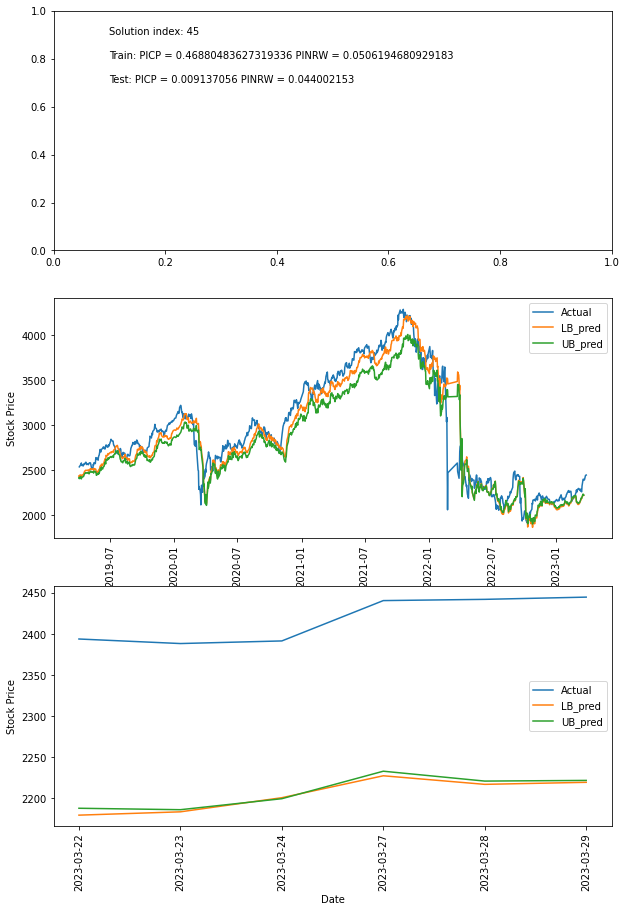

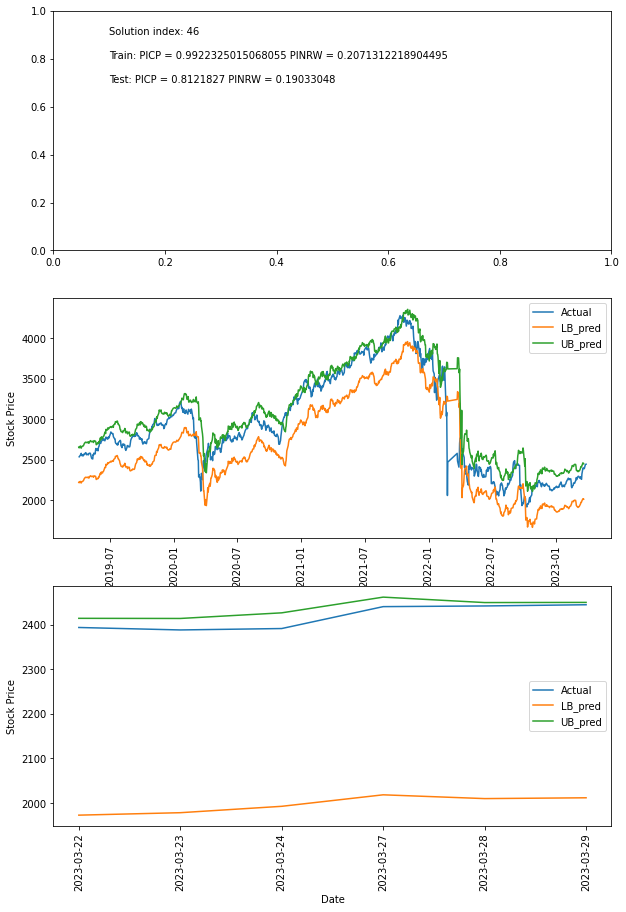

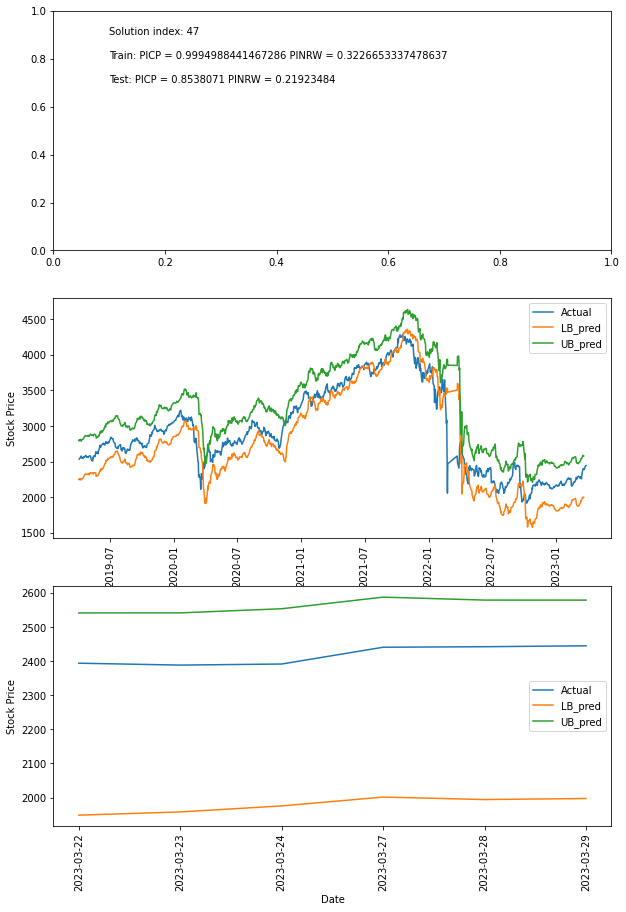

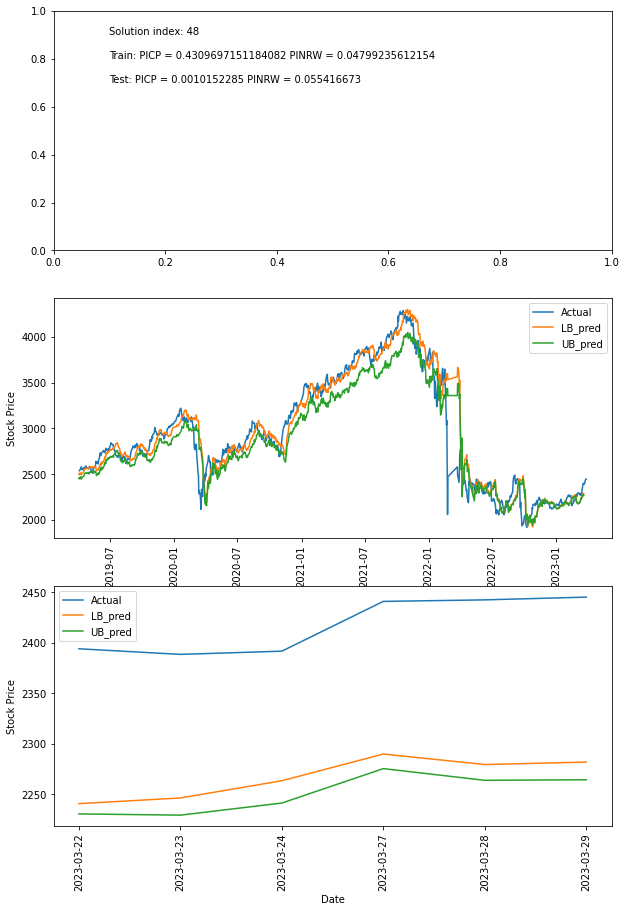

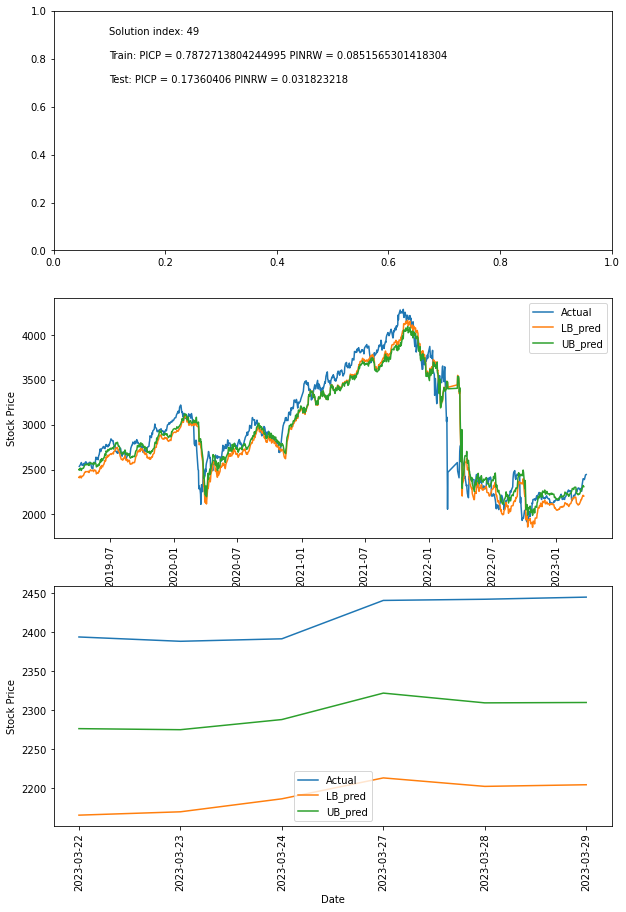

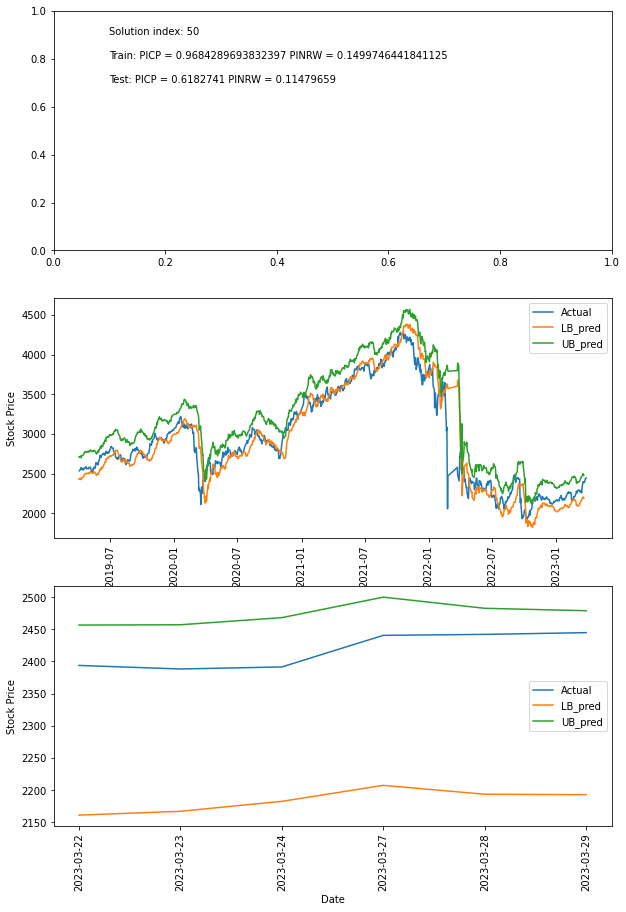

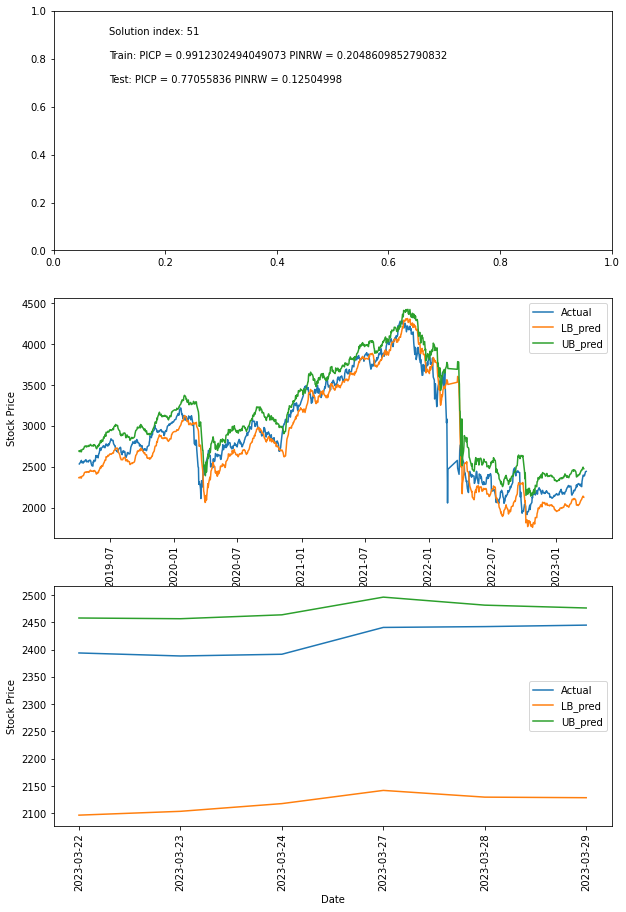

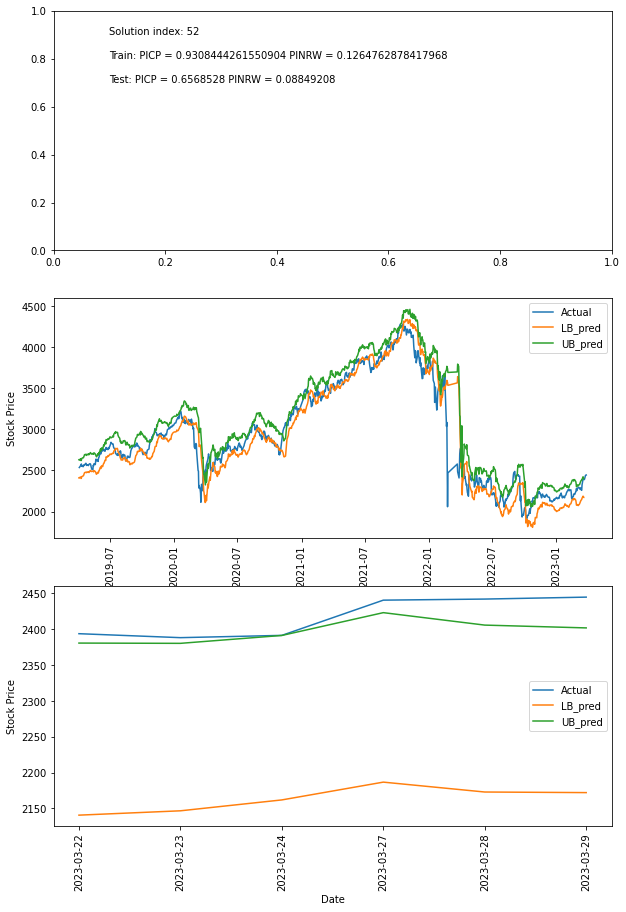

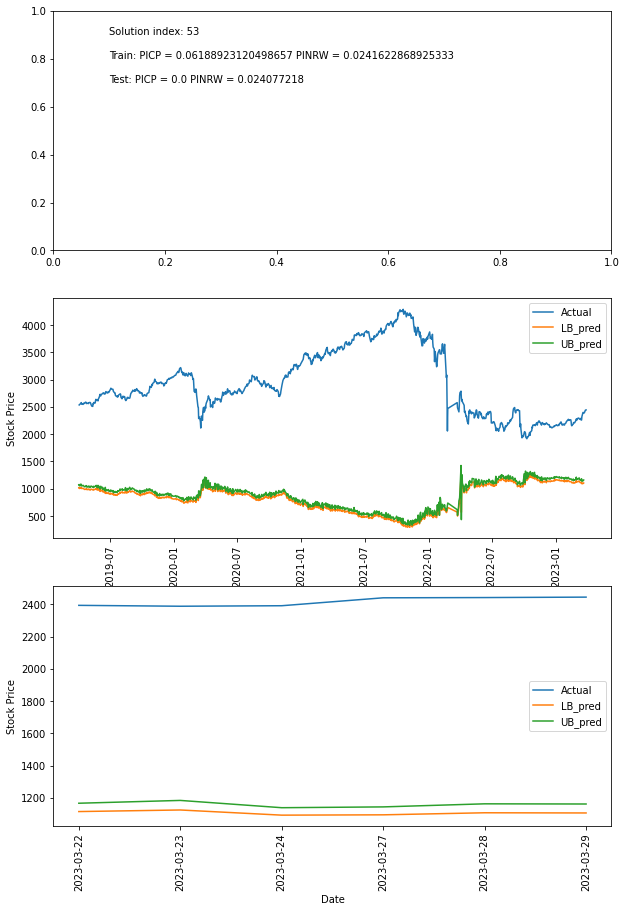

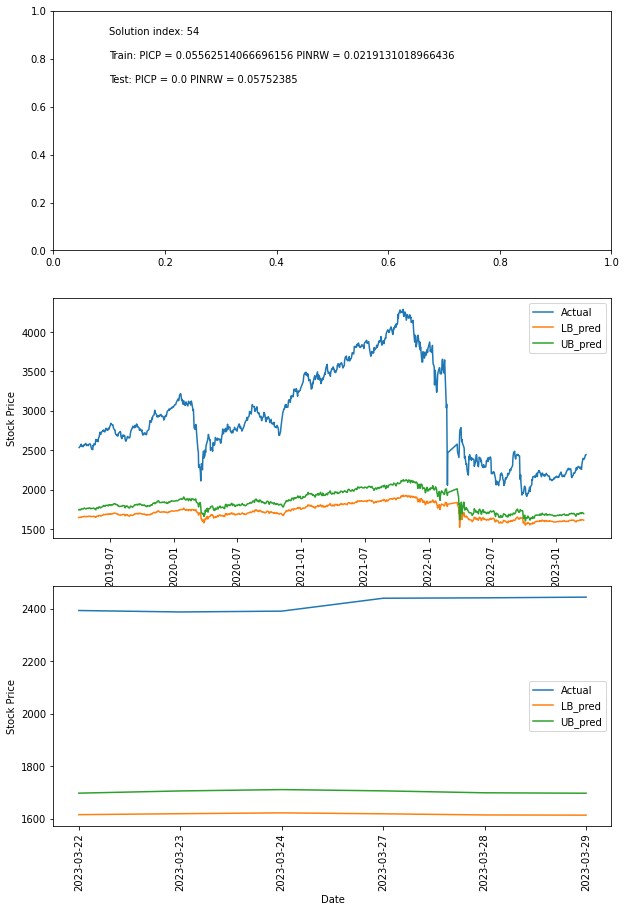

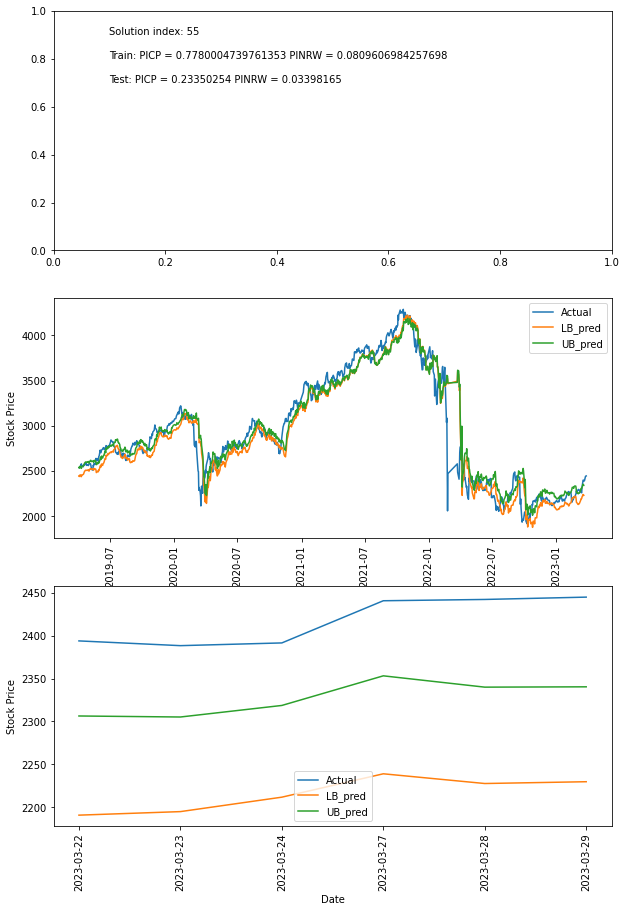

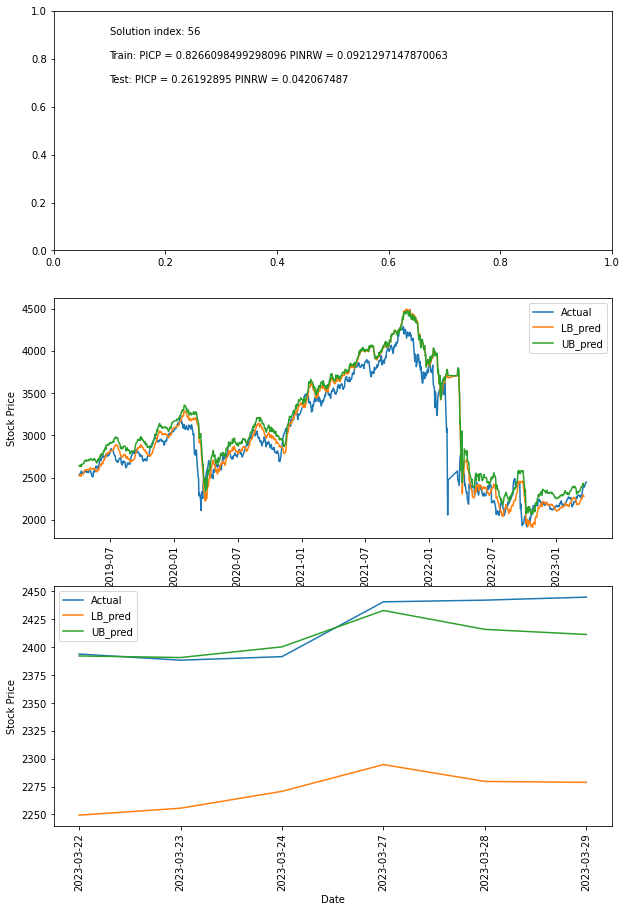

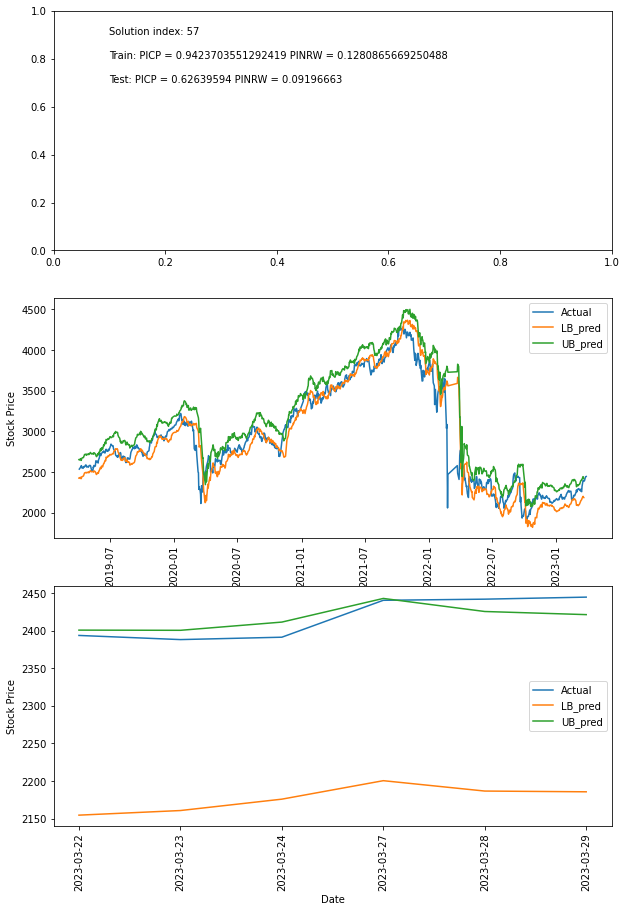

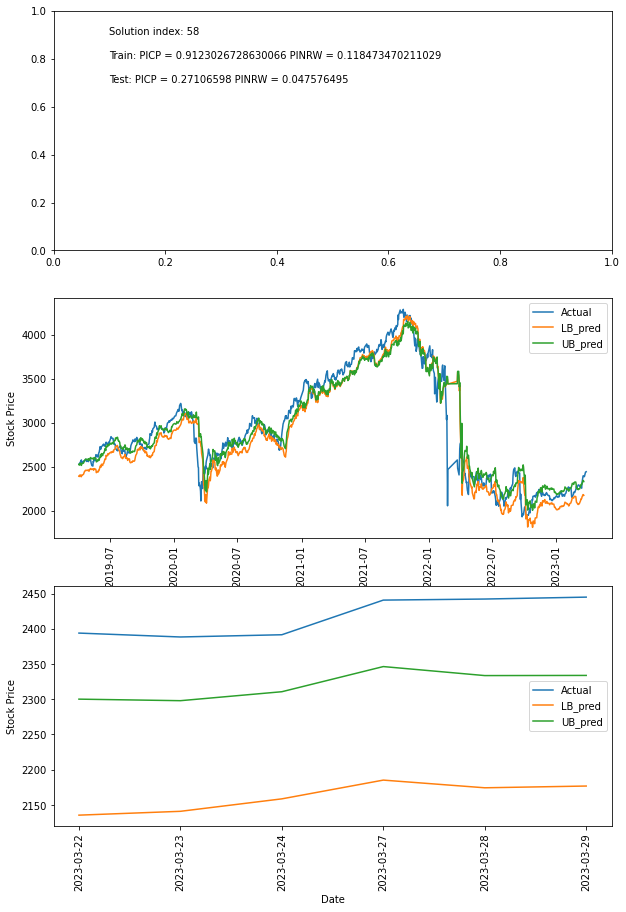

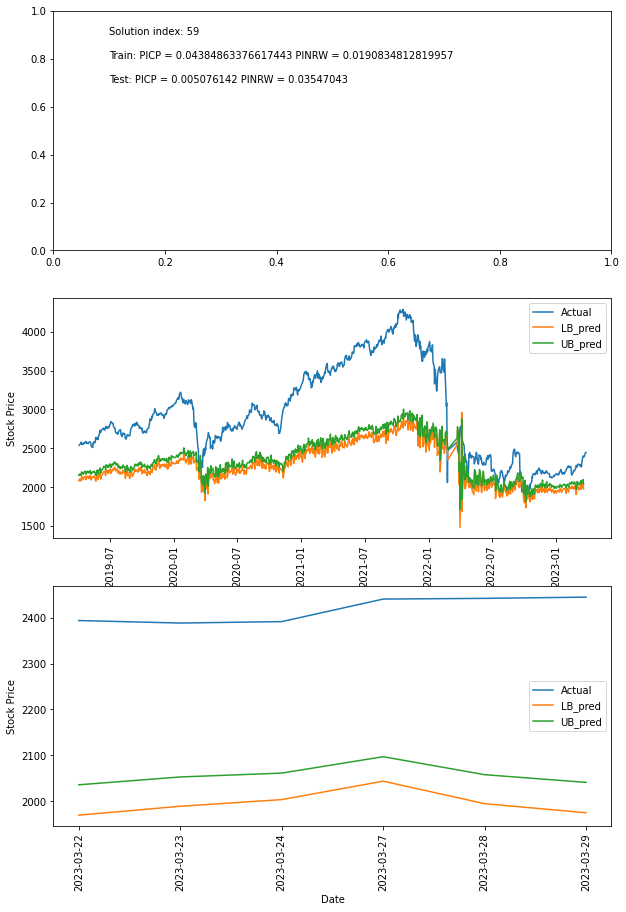

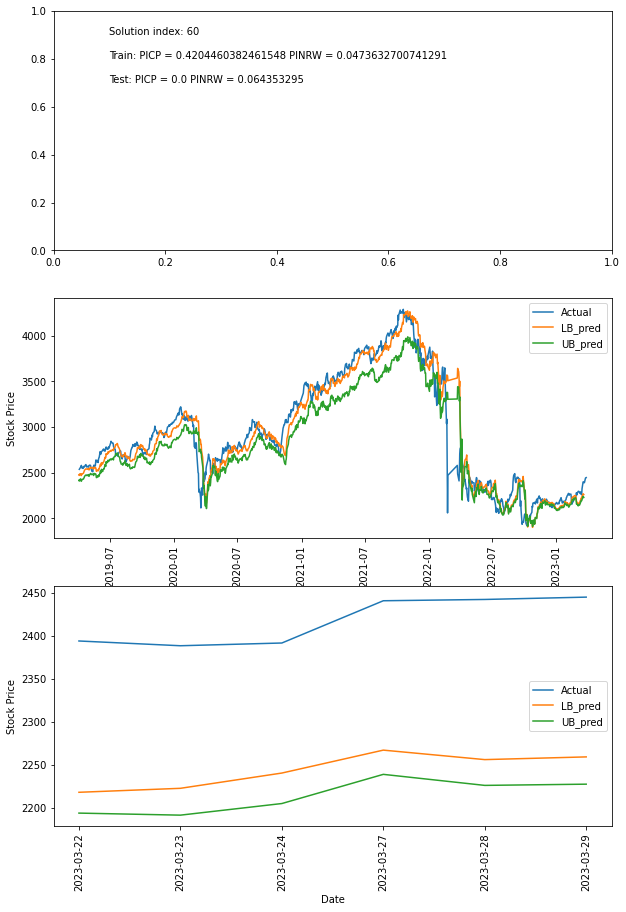

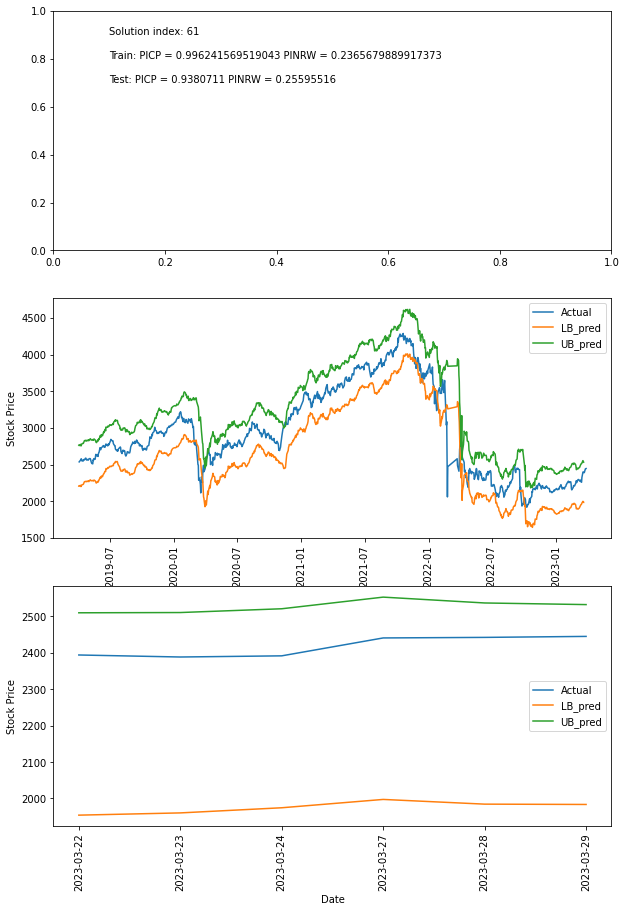

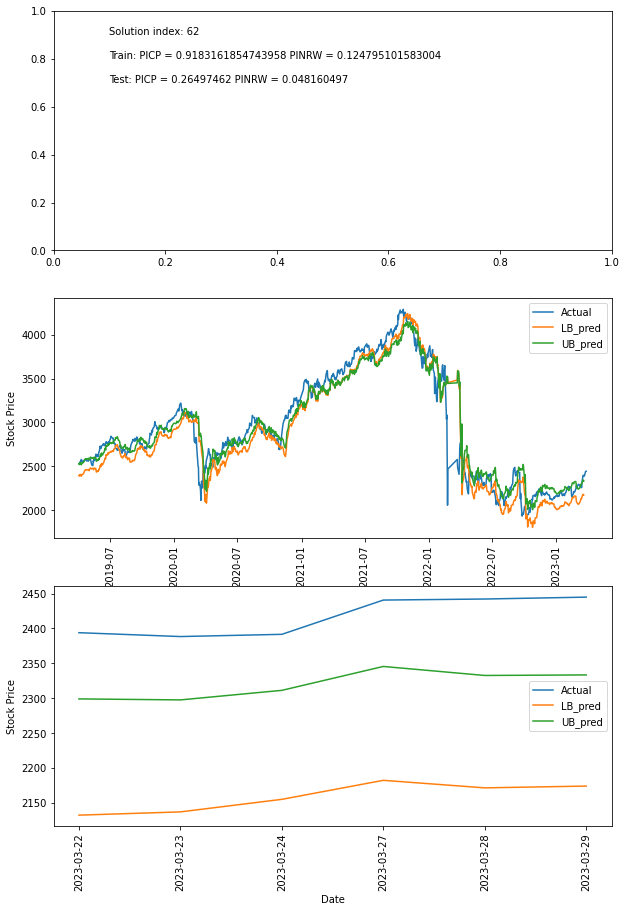

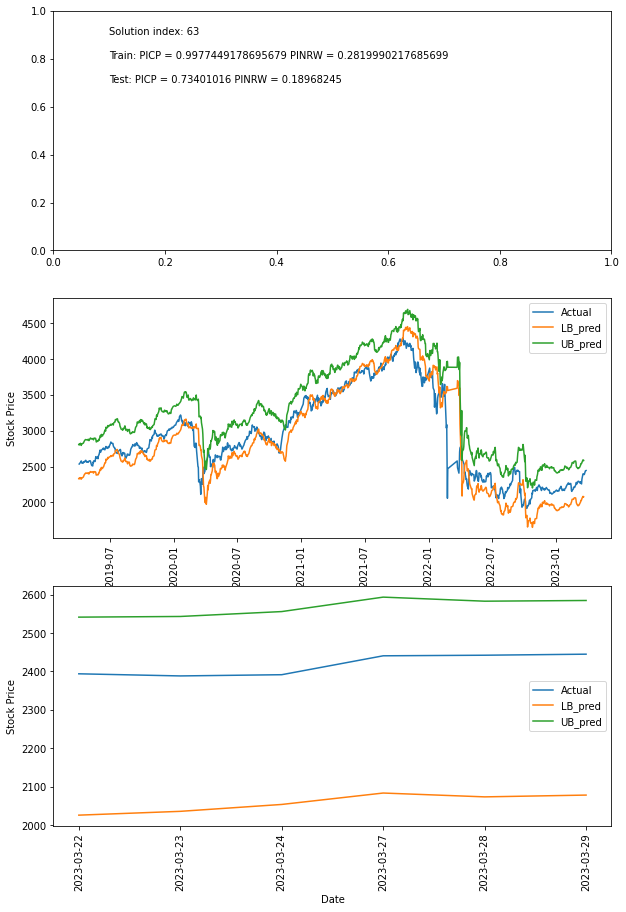

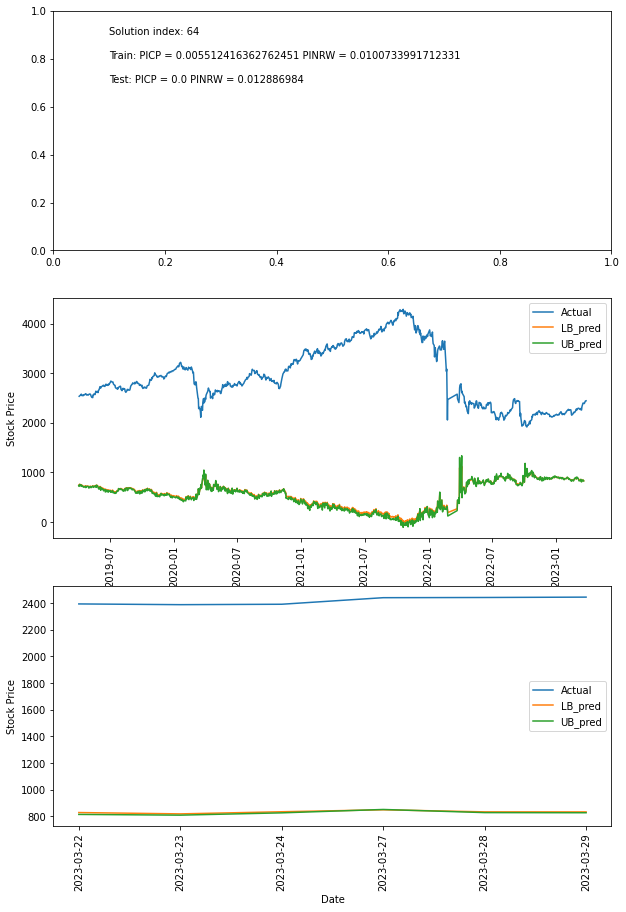

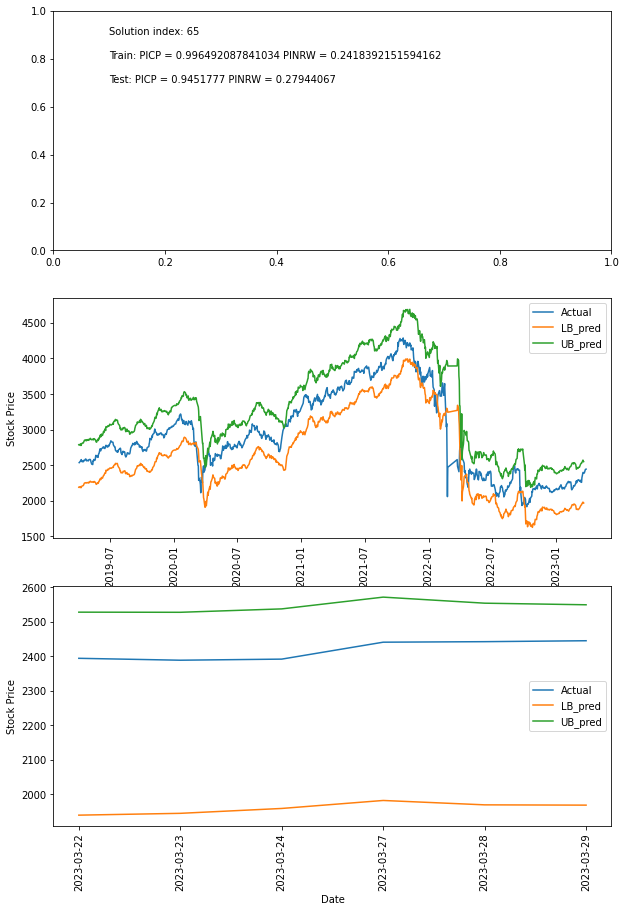

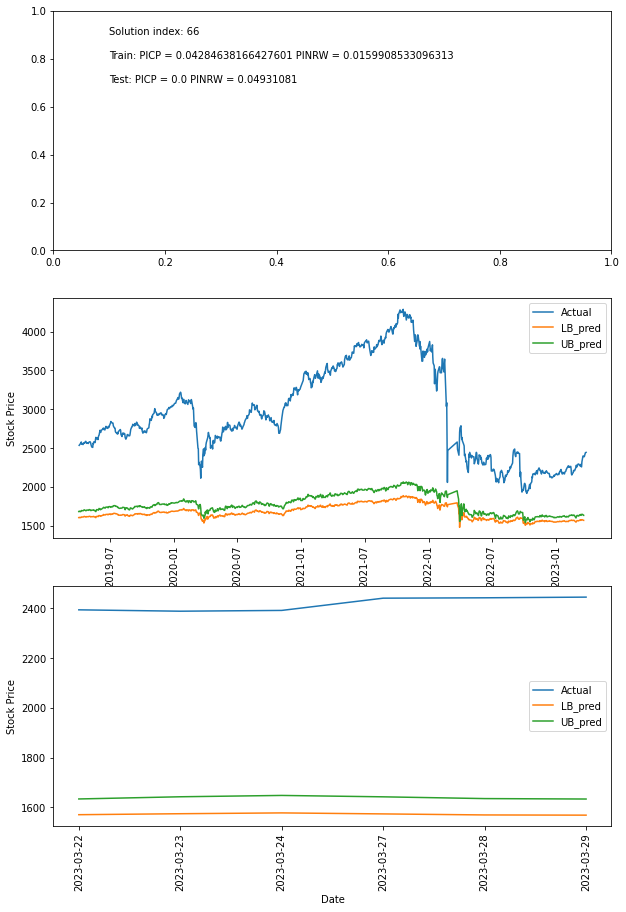

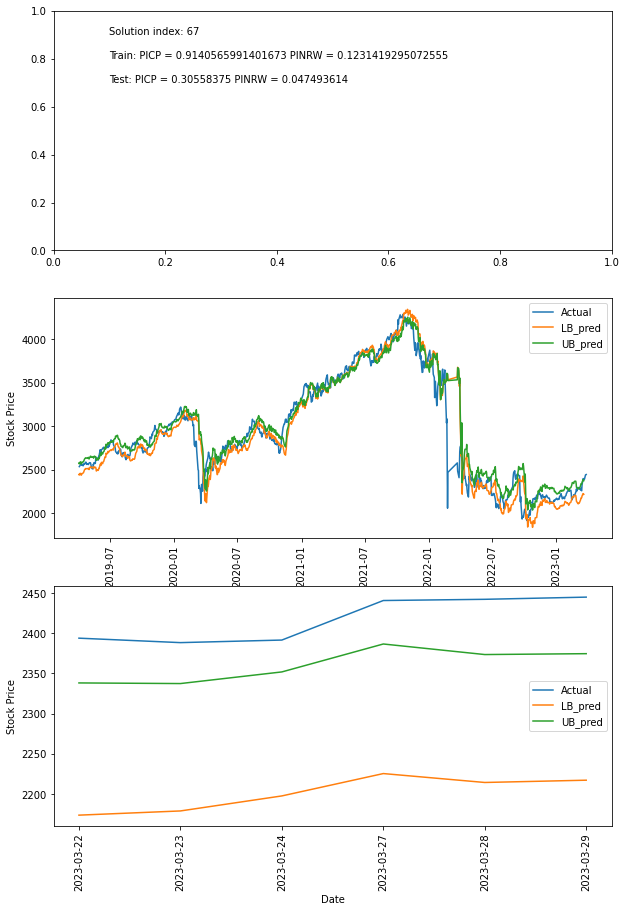

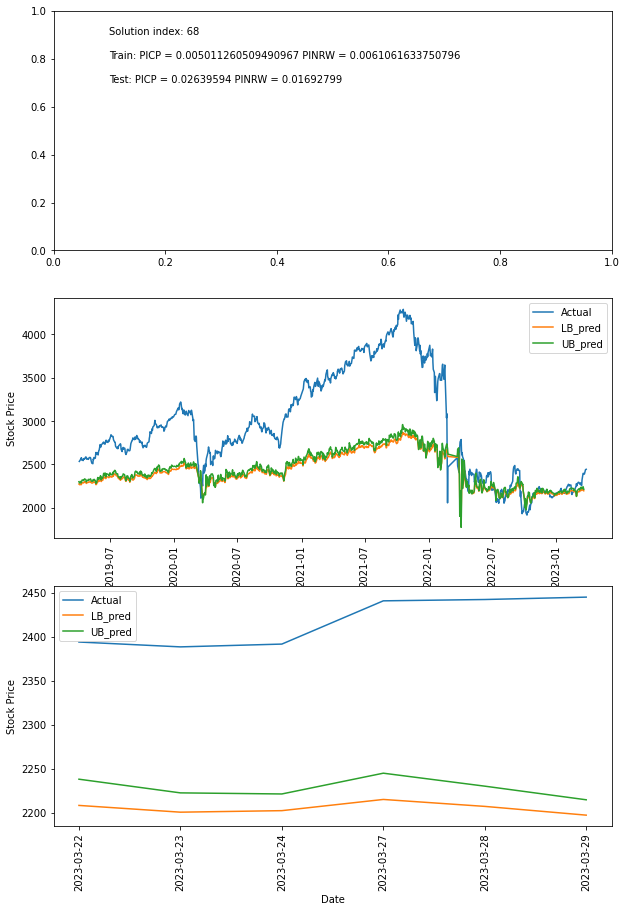

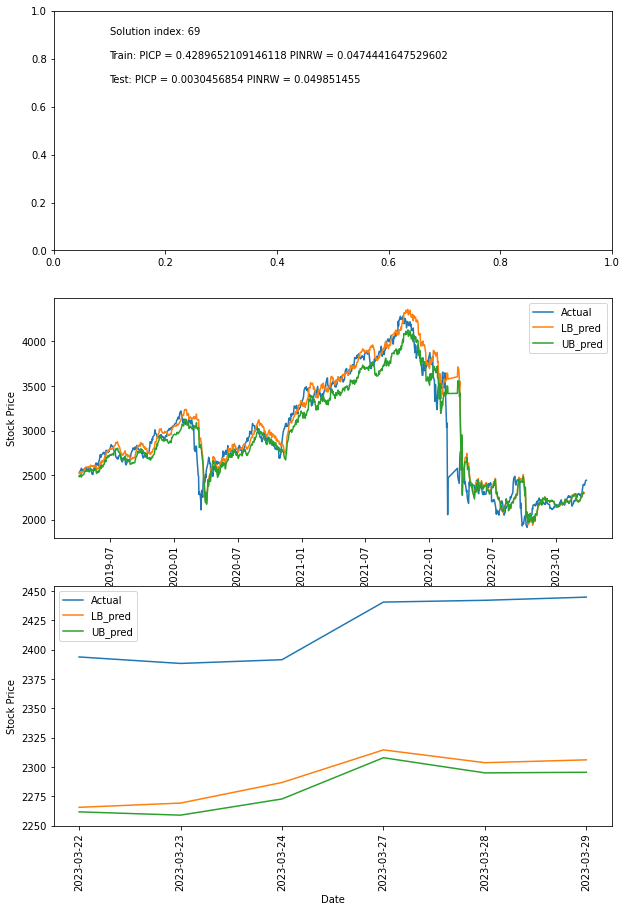

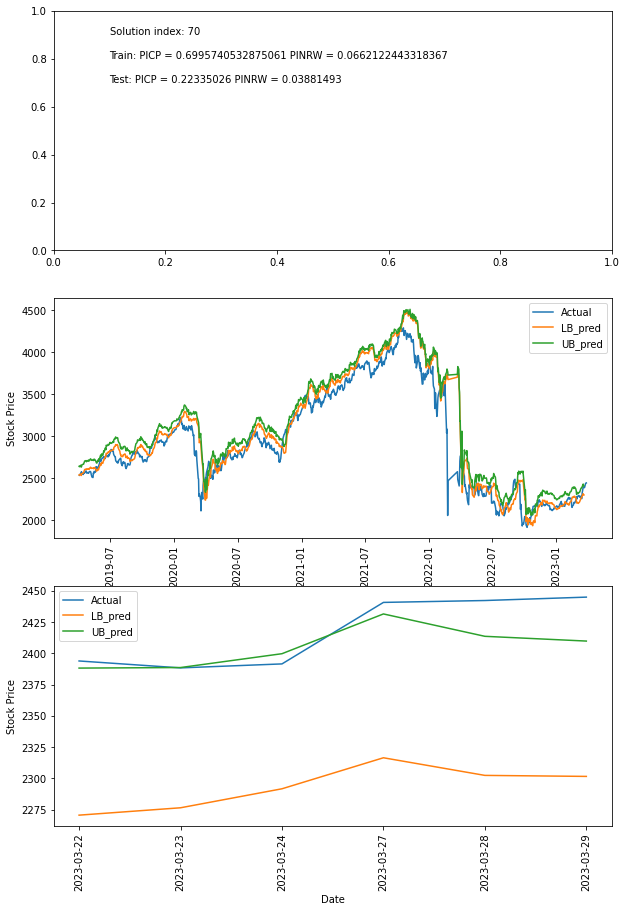

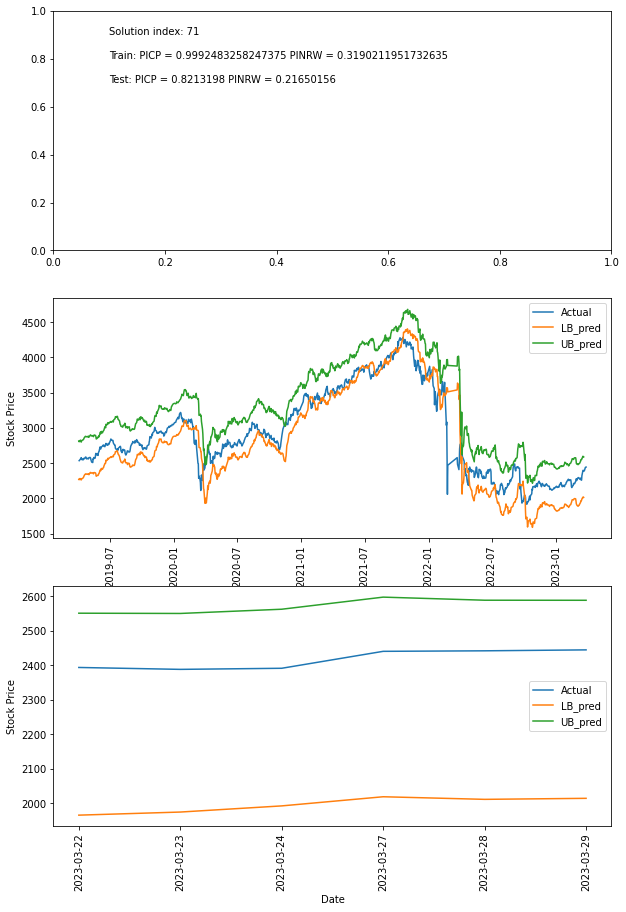

In [53]:
PICP_test = []
PINRW_test = []

with PdfPages('report_12.pdf') as pdf:
    for sol_ind in range(len(X)):
        model.set_weights(set_shape(X[sol_ind],shape))
        y_pred = model.predict(X_test, verbose = False)
        PICP_t = PICP(y_test, y_pred).numpy()
        PINRW_t = PINRW(y_pred).numpy()

        PICP_test.append(PICP_t)
        PINRW_test.append(PINRW_t)


        y_pred = scaler.inverse_transform(y_pred)


        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        
        # Add text to the plot
        axs[0].text(0.1, 0.9, 'Solution index: ' + str(sol_ind))
        axs[0].text(0.1, 0.8, 'Train: PICP = ' + str(1 - F[sol_ind, 0]) + ' PINRW = ' + str(F[sol_ind, 1]))
        axs[0].text(0.1, 0.7, 'Test: PICP = ' + str(PICP_t) + ' PINRW = ' + str(PINRW_t))

        # Plot the actual and predicted stock prices with the upper and lower bounds
        axs[1].plot(test['<DATE>'][13:], y_test_unscaled[1:], label='Actual')
        axs[1].plot(test['<DATE>'][12:-5], y_pred[:,0], label='LB_pred')
        axs[1].plot(test['<DATE>'][12:-5], y_pred[:,1], label='UB_pred')
        axs[1].legend()
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Stock Price')
        
        
        plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)

        # Plot the last three days
        last_dates = ('2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27','2023-03-28','2023-03-29')
        axs[2].plot(last_dates, y_test_unscaled[-6:], label='Actual')
        axs[2].plot(last_dates, y_pred[-6:,0], label='LB_pred')
        axs[2].plot(last_dates, y_pred[-6:,1], label='UB_pred')
        axs[2].legend()
        axs[2].set_xlabel('Date')
        axs[2].set_ylabel('Stock Price')
        plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

        # Save the figure to a PDF
        pdf.savefig(fig) 

        plt.show()

In [ ]:
metrics_df = pd.DataFrame({'PICP_train': 1 - F[:, 0], 'PINRW_train': F[:, 1], 'PICP_test': PICP_test, 'PINRW_test': PINRW_test})


In [155]:
metrics_df.to_csv('metrics.csv')

NameError: name 'metrics_df' is not defined

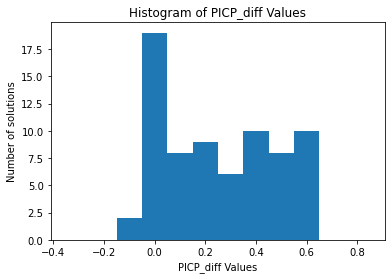

In [57]:
picp_diff_values = 1 - F[:,0] - PICP_test

# Создаем гистограмму
plt.hist(picp_diff_values, bins=np.arange(-0.3, 1, 0.1), align='left')

plt.xlabel('PICP_diff Values')
plt.ylabel('Number of solutions')
plt.title('Histogram of PICP_diff Values')

# Отображаем гистограмму
plt.show()

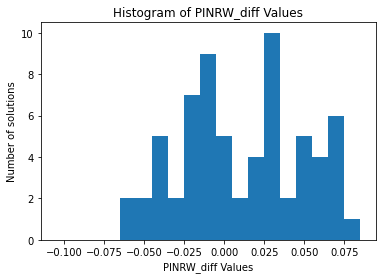

In [61]:
pinrw_diff_values = F[:, 1] - PINRW_test

# Создаем гистограмму
plt.hist(pinrw_diff_values, bins=np.arange(-0.1, 0.1, 0.01), align='left')

plt.xlabel('PINRW_diff Values')
plt.ylabel('Number of solutions')
plt.title('Histogram of PINRW_diff Values')

# Отображаем гистограмму
plt.show()